## Imports

In [3]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from config import *
from data import *
from net import *
from task import *
from test_funcs import *

import Tasks
from Tasks.util import register_all_tasks
register_all_tasks()

## Model Tuning
### Example model import and evaluation

In [ ]:
# Head Direction, Shelter Direction, 0D (HD_SD-0D)
# Weight and Rate Regularisation L2 = 0.0
# checkpoint_path = 'trained-models/1737140920.5501454-task:HD_SD-0D-weight_lambda:0.0-rate_lambda:0.0/checkpoint-epochs:116000/net.pt'

# Weight and Rate Regularisation L2 = 0.0001
# checkpoint_path = 'trained-models/1737140920.5501454-task:HD_SD-0D-weight_lambda:0.0001-rate_lambda:0.0001/checkpoint-epochs:115500/net.pt'

# Weight and Rate Regularisation L2 = 0.01
checkpoint_path = 'trained-models/1737566092.4583075-task:HD_SD-0D-rate_lambda:0.01-weight_lambda:0.01/checkpoint-epochs:72000/net.pt'

# Weight and Rate Regularisation L2 = 0.1
# checkpoint_path = 'trained-models/1737140920.5501454-task:HD_SD-0D-weight_lambda:0.1-rate_lambda:0.1/checkpoint-epochs:117400/net.pt'

# Weight and Rate Regularisation L2 = 0.5
# checkpoint_path = 'trained-models/1737140920.5501454-task:HD_SD-0D-weight_lambda:0.5-rate_lambda:0.5/checkpoint-epochs:116700/net.pt'

'''
Standard idiom for loading a model from a checkpoint and getting a testing batch to evaluate the model on.
'''

# Load model save from path
checkpoint = torch.load(checkpoint_path, map_location='cpu')
task = Task.from_checkpoint(checkpoint=checkpoint)
task.config.update(device='cpu', batch_size=2500)
net = RNN(task)
net.load_state_dict(checkpoint['net_state_dict'])
batch = TaskDataset(task, for_training=False).get_batch()



# Get loss on testing batch
loss,_ = task.get_loss(net=net, batch=batch)
print(f'Test set loss: {loss:.6f}')

# Generate tuning curve figures
figs = test_tuning(task, net, batch, checkpoint_path=checkpoint_path, **task.test_func_args)

# Manifold Tracing

### Testing Head Direction, Shelter Direction, 0D Model w/ Weight and Rate L2 Regularisation 0.01

In [4]:
checkpoint_path = 'trained-models/1737566092.4583075-task:HD_SD-0D-rate_lambda:0.01-weight_lambda:0.01/checkpoint-epochs:72000/net.pt'
checkpoint = torch.load(checkpoint_path, map_location='cpu')
task = Task.from_checkpoint(checkpoint=checkpoint)
task.config.update(device='cpu')
net = RNN(task)
net.load_state_dict(checkpoint['net_state_dict'])

<All keys matched successfully>

## HD-Varying Task
- Fixed Initial State (`net.x_0`), Head-Shelter Angle (SD $ = \frac{\pi}{2}$)
- Varying Head Direction (HD $ \in [0, 2\pi]$)
- No angular velocity ($\dot{\theta}=0$)

## SD-Varying Task
- Fixed Initial State (`net.x_0`), Head Direction (SD $ = \frac{\pi}{2}$)
- Varying Head-Shelter Angle (SD $ \in [0, 2\pi]$)
- No angular velocity ($\dot{\theta}=0$)

### Programmatic Task Definition

In [5]:

def fill_hd_sd_0d_data(config, inputs, targets, vars, mask):
    """
    Fills the input, target, and mask tensors with head direction (hd) and shelter direction (sd) data (which
    data is generated elsewhere)
    Args:
        config (object): Configuration object containing batch_size, n_timesteps, and init_duration.
        inputs (torch.Tensor): Input tensor to be filled.
        targets (torch.Tensor): Target tensor to be filled.
        vars (dict): Dictionary containing variables 'av', 'hd', 'sd', 'sx', and 'sy'.
        mask (torch.Tensor): Mask tensor to be updated.
    Returns:
        tuple: Updated inputs, targets, vars, and mask tensors.
    """

    batch_size, n_timesteps, init_duration = config.batch_size, config.n_timesteps, config.init_duration

    inputs[:,:,Tasks.vars_0D.input_map['av']] = vars['av']
    inputs[:,:init_duration,Tasks.vars_0D.input_map['sin_hd_0']] = torch.sin(vars['hd'][:,0]).reshape((batch_size,1)).repeat((1,init_duration))
    inputs[:,:init_duration,Tasks.vars_0D.input_map['cos_hd_0']] = torch.cos(vars['hd'][:,0]).reshape((batch_size,1)).repeat((1,init_duration))
    inputs[:,:init_duration,Tasks.vars_0D.input_map['sx']] = vars['sx'].repeat((1,init_duration))
    inputs[:,:init_duration,Tasks.vars_0D.input_map['sy']] = vars['sy'].repeat((1,init_duration))

    mask[:,:init_duration] = False

    targets[:,:,Tasks.HD_SD_0D.target_map['sin_hd']] = torch.sin(vars['hd'])
    targets[:,:,Tasks.HD_SD_0D.target_map['cos_hd']] = torch.cos(vars['hd'])
    targets[:,:,Tasks.HD_SD_0D.target_map['sin_sd']] = torch.sin(vars['sd'])
    targets[:,:,Tasks.HD_SD_0D.target_map['cos_sd']] = torch.cos(vars['sd'])

    return inputs, targets, vars, mask


def create_hd_varying_data(config, inputs, targets, mask):
    """
    Generate head direction varying (shelter direction fixed) data for a batch of sequences.
    Createes the ground-truth data to be put into the batch tensors by `fill_hd_sd_0d_data`.
    Args:
        config (object): Configuration object containing batch_size, n_timesteps, and init_duration.
        inputs (torch.Tensor): Input tensor to be filled with generated data.
        targets (torch.Tensor): Target tensor to be filled with generated data.
        mask (torch.Tensor): Mask tensor.
    Returns:
        tuple: Updated inputs, targets, vars, and mask tensors.
    """

    batch_size, n_timesteps, init_duration = config.batch_size, config.n_timesteps, config.init_duration

    # Draw head direction regularly from [0, 2pi] across the batch
    head_direction = torch.linspace(0, 2*np.pi, batch_size).reshape((batch_size,1)).repeat((1,n_timesteps))

    # Keep shelter direction fixed at pi/2
    ego_shelter_angle = torch.ones((batch_size,1)) * np.pi/2

    # Construct absolute shelter direction accordingly
    allo_shelter_angle = torch.remainder(head_direction + ego_shelter_angle, 2*np.pi)[:,0].reshape((batch_size,1))

    vars = {'av': torch.zeros((batch_size, n_timesteps)), 
            'hd': head_direction, 
            'sd': ego_shelter_angle,
            'sx': torch.cos(allo_shelter_angle), 
            'sy': torch.sin(allo_shelter_angle)}
    
    return fill_hd_sd_0d_data(config, inputs, targets, vars, mask) 


def create_sd_varying_data(config, inputs, targets, mask):
    """
    Generate shelter direction varying (head direction fixed) data for a batch of sequences.
    Createes the ground-truth data to be put into the batch tensors by `fill_hd_sd_0d_data`.
    Args:
        config (object): Configuration object containing batch_size, n_timesteps, and init_duration.
        inputs (torch.Tensor): Input tensor to be filled with generated data.
        targets (torch.Tensor): Target tensor to be filled with generated data.
        mask (torch.Tensor): Mask tensor.
    Returns:
        tuple: Updated inputs, targets, vars, and mask tensors.
    """
    batch_size, n_timesteps, init_duration = config.batch_size, config.n_timesteps, config.init_duration

    # Keep head direction fixed at pi/2
    head_direction = torch.ones((batch_size,1)) * np.pi/2

    # Draw shelter direction regularly from [0, 2pi] across the batch
    ego_shelter_angle = torch.linspace(0, 2*np.pi, batch_size).reshape((batch_size,1)).repeat((1,n_timesteps))

    # Construct absolute shelter direction accordingly
    allo_shelter_angle = torch.remainder(head_direction + ego_shelter_angle, 2*np.pi)[:,0].reshape((batch_size,1))

    vars = {'av': torch.zeros((batch_size, n_timesteps)), 
            'hd': head_direction, 
            'sd': ego_shelter_angle,
            'sx': torch.cos(allo_shelter_angle), 
            'sy': torch.sin(allo_shelter_angle)}
    
    return fill_hd_sd_0d_data(config, inputs, targets, vars, mask)


# Instantiate the tasks (apart from structured data above, only other difference from training is no noise in voltages (state_noise_std))
test_batch_size, test_n_timesteps = 10000, 100

hd_iso_task = Task.named('HD_SD-0D', create_data_func=create_hd_varying_data)
hd_iso_task.config.update(batch_size=test_batch_size, n_timesteps=test_n_timesteps, state_noise_std=0)

sd_iso_task = Task.named('HD_SD-0D', create_data_func=create_sd_varying_data)
sd_iso_task.config.update(batch_size=test_batch_size, n_timesteps=test_n_timesteps, state_noise_std=0)


## Dimensionality of Activity

In [6]:
from sklearn.decomposition import PCA

def get_iso_subspaces_at_time(eval_t, max_components=2, activity=None):
    """
    Compute the PCA subspaces of head-direction and shelter-direction varying tasks at a given time point.
    Parameters:
    eval_t (int): The time point at which to evaluate the activities.
    max_components (int, optional): The maximum number of principal components to retain. Default is 2.
    activity (tuple, optional): A tuple containing precomputed hd_activity and sd_activity. 
                                If None, activities are computed from a fresh testing batch.
    Returns:
    tuple: A tuple containing:
        - hd_batch (dict or None): The batch of head-direction varying data used, or None if activity is provided.
        - sd_batch (dict or None): The batch of shelter-direction varying data used, or None if activity is provided.
        - hd_pca (PCA object): The PCA object fitted on head-direction varying activity.
        - sd_pca (PCA object): The PCA object fitted on shelter-direction varying activity.
        - hd_pca_activity (ndarray): The transformed head-direction varying activity.
        - sd_pca_activity (ndarray): The transformed shelter-direction varying activity.
    """

    if activity is None:
        hd_batch = TaskDataset(hd_iso_task).get_batch()
        sd_batch = TaskDataset(sd_iso_task).get_batch()

        hd_activity = net(hd_batch['inputs'], noise=hd_batch['noise'])[1].detach().numpy() 
        sd_activity = net(sd_batch['inputs'], noise=sd_batch['noise'])[1].detach().numpy()
    else:
        hd_batch, sd_batch = None, None
        hd_activity, sd_activity = activity 

    hd_pca = PCA(n_components=max_components)
    hd_pca_activity = hd_pca.fit_transform(hd_activity[:,eval_t].reshape((-1, net.n_neurons)))

    sd_pca = PCA(n_components=max_components)
    sd_pca_activity = sd_pca.fit_transform(sd_activity[:, eval_t].reshape((-1, net.n_neurons)))

    return hd_batch, sd_batch, hd_pca, sd_pca, hd_pca_activity, sd_pca_activity

eval_t = 50
hd_batch, sd_batch, hd_pca, sd_pca, hd_pca_activity, sd_pca_activity = get_iso_subspaces_at_time(eval_t, max_components=10)

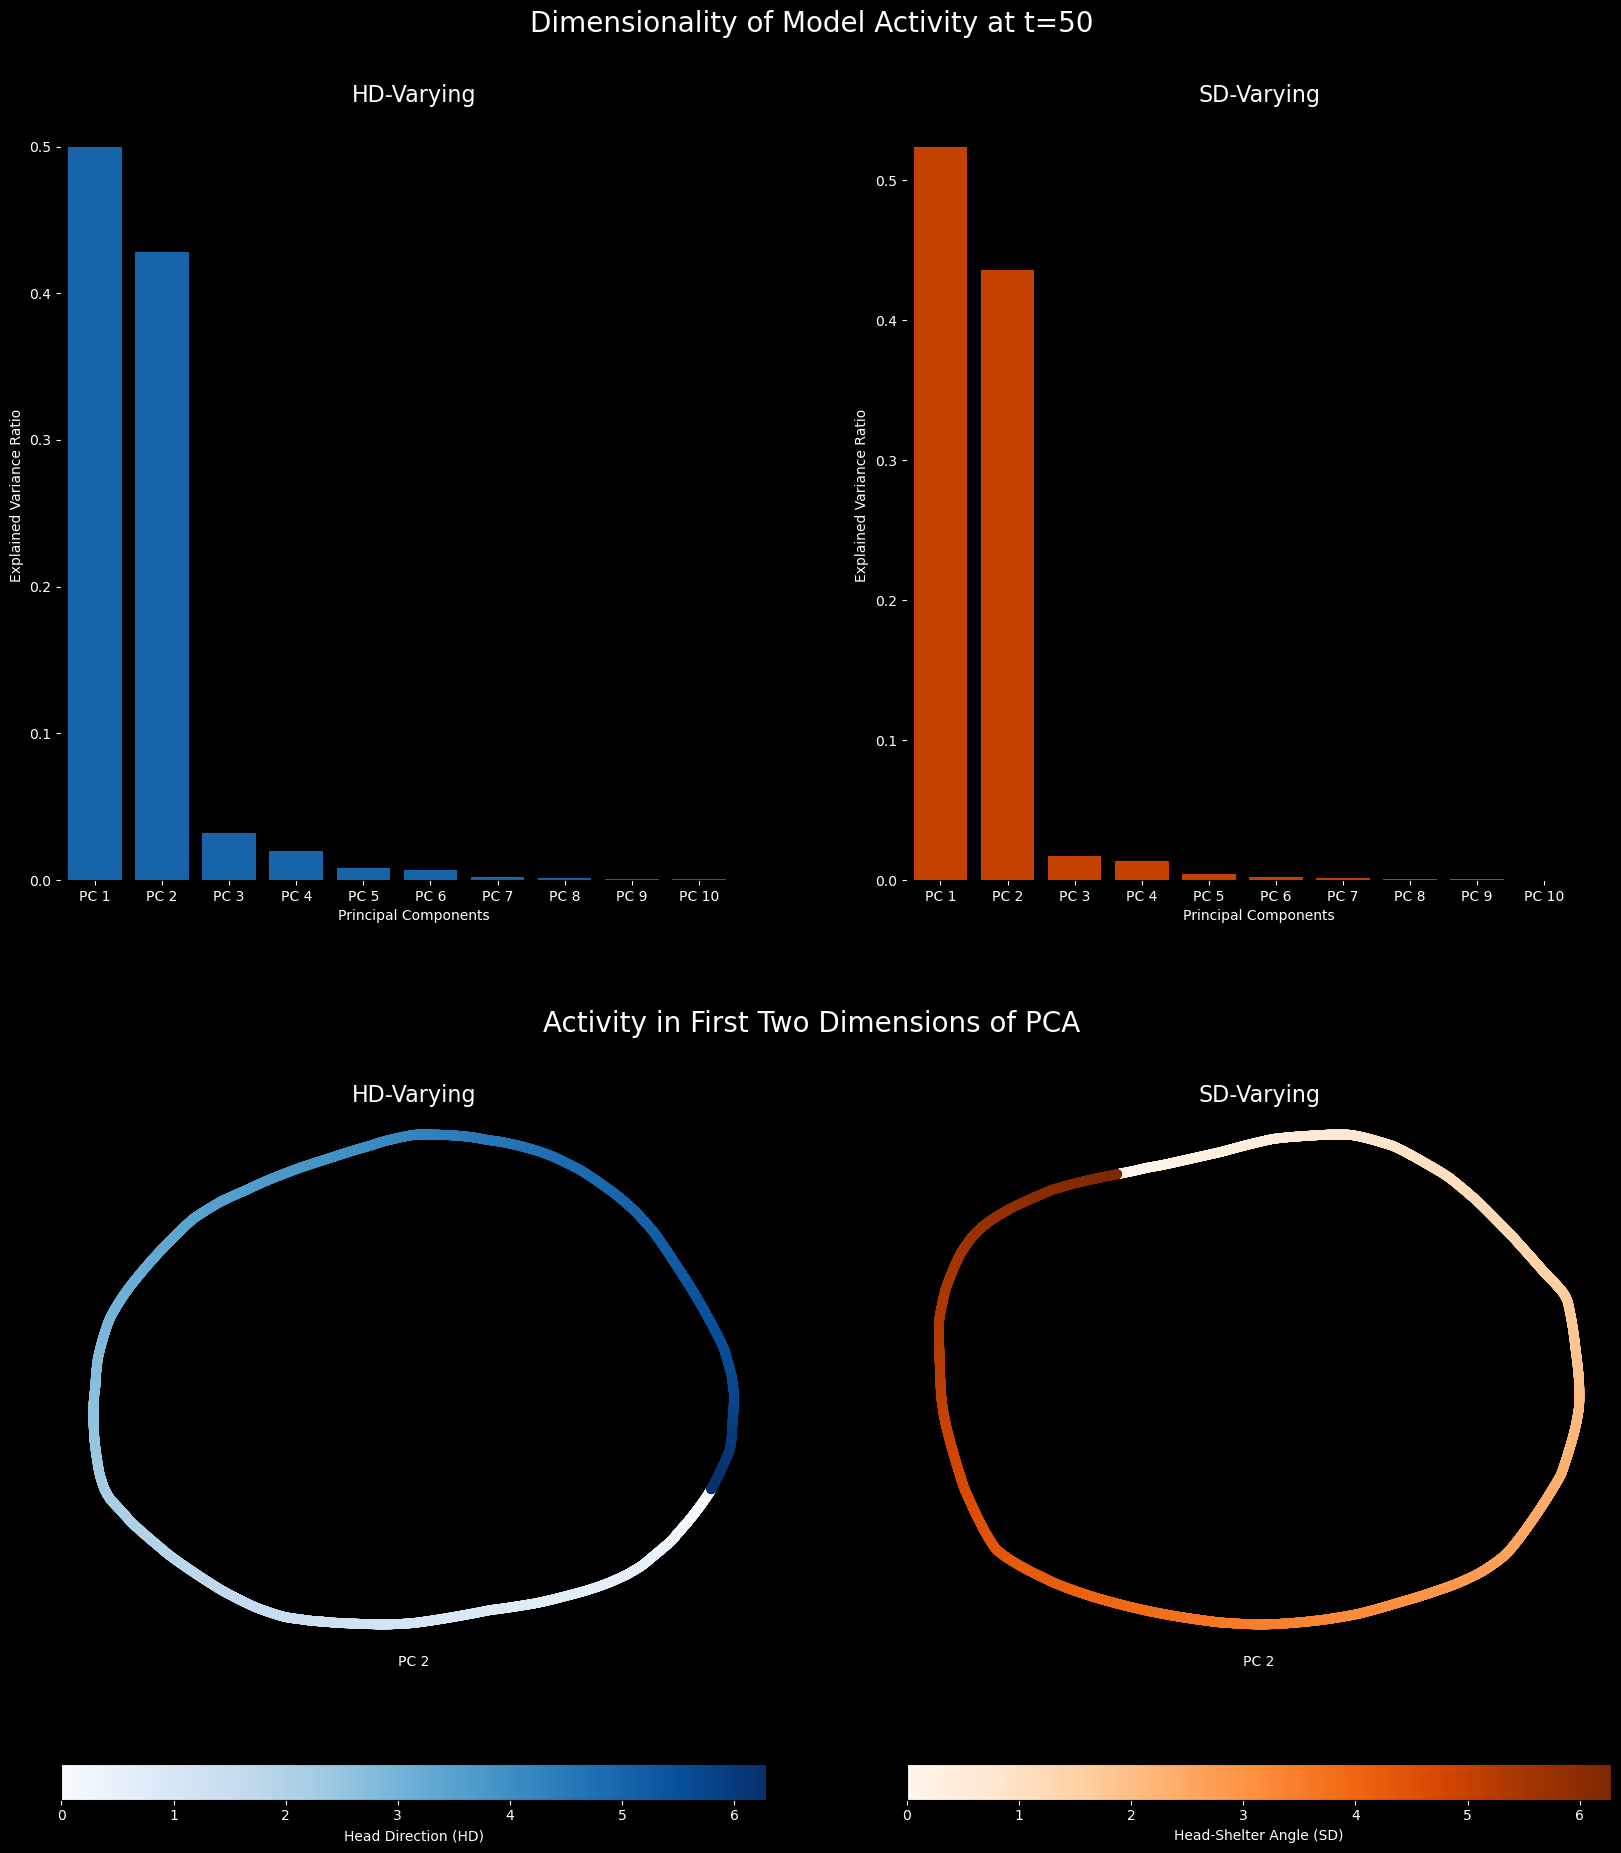

In [7]:
"""
Figure corresponding to the dimensionality of the model activity at a given time point, and the activity in the first two principal components of PCA,
in each of the two tasks (head-direction varying and shelter-direction varying).

"""
hd_cmap = matplotlib.colormaps['Blues']
sd_cmap = matplotlib.colormaps['Oranges']
norm = matplotlib.colors.Normalize(vmin=0, vmax=2*np.pi)

fig = plt.figure(figsize=(20,20))
outer_gs = fig.add_gridspec(nrows=2, ncols=2)

dim_subfig = fig.add_subfigure(outer_gs[0,:])
dim_gs = dim_subfig.add_gridspec(ncols=2)
dim_subfig.suptitle(f'Dimensionality of Model Activity at t={eval_t}', fontsize=20)

hd_dim_ax = dim_subfig.add_subplot(dim_gs[0,0])

x = 1 + np.arange(hd_pca.n_components_, dtype=int)
hd_dim_ax.bar(x, hd_pca.explained_variance_ratio_, color=hd_cmap(0.8))

hd_dim_ax.set_xlim([0.5, hd_pca.n_components_ + 1])
hd_dim_ax.set_xticks(x)
hd_dim_ax.set_xticklabels([f"PC {i+1}" for i in range(hd_pca.n_components_)])
hd_dim_ax.set_xlabel("Principal Components")
hd_dim_ax.set_ylabel("Explained Variance Ratio")
hd_dim_ax.set_title('HD-Varying', fontsize=16)



sd_dim_ax = dim_subfig.add_subplot(dim_gs[0,1])

x = 1 + np.arange(sd_pca.n_components_, dtype=int)
sd_dim_ax.bar(x, sd_pca.explained_variance_ratio_, color=sd_cmap(0.8))

sd_dim_ax.set_xlim([0.5, sd_pca.n_components_ + 1])
sd_dim_ax.set_xticks(x)
sd_dim_ax.set_xticklabels([f"PC {i+1}" for i in range(sd_pca.n_components_)])
sd_dim_ax.set_xlabel("Principal Components")
sd_dim_ax.set_ylabel("Explained Variance Ratio")
sd_dim_ax.set_title('SD-Varying', fontsize=16)



ring_subfig = fig.add_subfigure(outer_gs[1,:])
ring_gs = ring_subfig.add_gridspec(ncols=2)
ring_subfig.suptitle('Activity in First Two Dimensions of PCA', fontsize=20)

hd_ring_ax = ring_subfig.add_subplot(ring_gs[0,0])

hd_ring_plot = hd_ring_ax.scatter(hd_pca_activity[:,0], hd_pca_activity[:,1], c=hd_batch['vars']['hd'][:,10], cmap=hd_cmap, norm=norm)

hd_ring_ax.set_xlabel('PC 1')
hd_ring_ax.set_xlabel('PC 2')
hd_ring_ax.set_xticks([])
hd_ring_ax.set_yticks([])
hd_ring_ax.set_title('HD-Varying', fontsize=16)

cbar = fig.colorbar(hd_ring_plot, orientation='horizontal')
cbar.set_label('Head Direction (HD)')


sd_ring_ax = ring_subfig.add_subplot(ring_gs[0,1])

sd_ring_plot = sd_ring_ax.scatter(sd_pca_activity[:,0], sd_pca_activity[:,1], c=sd_batch['vars']['sd'][:,10], cmap=sd_cmap, norm=norm)

sd_ring_ax.set_xlabel('PC 1')
sd_ring_ax.set_xlabel('PC 2')
sd_ring_ax.set_xticks([])
sd_ring_ax.set_yticks([])
sd_ring_ax.set_title('SD-Varying', fontsize=16)

cbar = fig.colorbar(sd_ring_plot, orientation='horizontal')
cbar.set_label('Head-Shelter Angle (SD)')

plt.show()

## Similarity Between Subspaces

In [8]:







def get_iso_vector_similarity_at_time(eval_t, max_components=2):
    """
    Compute the cosine similarity between principal component vectors and input/output vectors at a given time.
    Parameters:
    eval_t (float): The evaluation time at which to compute the principal components.
    max_components (int, optional): The maximum number of principal components to consider. Default is 2.
    Returns:
    np.ndarray: A matrix of cosine similarities between the principal component vectors and the input/output vectors.
    """
    
    # Extract input and output vectors
    in_vectors = net.W_in.weight.detach().numpy()
    out_vectors = net.W_out.weight.detach().T.numpy()

    # Get the principal components
    hd_pca, sd_pca = get_iso_subspaces_at_time(eval_t, max_components=max_components)[2:4]
    pc_vectors = np.concatenate((hd_pca.components_, sd_pca.components_), axis=0).T

    # Collate all vectors into matrices
    all_vectors = np.concatenate((pc_vectors, in_vectors, out_vectors), axis=1)

    # Rescale columns to be length 1
    pc_vectors = pc_vectors / np.linalg.norm(pc_vectors, axis=0, keepdims=True)
    all_vectors = all_vectors / np.linalg.norm(all_vectors, axis=0, keepdims=True)

    # Compute cosine similarity by matrix multiplication
    pc_sim = pc_vectors.T @ all_vectors

    return pc_sim

def get_norms(M_A, M_B):
    """
    Compute the spectral norm and nuclear norm of the product of the orthogonal matrices 
    obtained from the QR decompositions of two input matrices.
    Parameters:
    M_A (numpy.ndarray): The first input matrix.
    M_B (numpy.ndarray): The second input matrix.
    Returns:
    tuple: A tuple containing:
        - spectral_norm (float): The largest singular value of the product Q_A^T Q_B.
        - nuclear_norm (float): The sum of the singular values of the product Q_A^T Q_B.
    """

    # 1. Perform QR decomposition on the input matrices
    Q_A, R_A = np.linalg.qr(M_A, mode='reduced')
    Q_B, R_B = np.linalg.qr(M_B, mode='reduced')

    # 2. Form the r x r product Q_A^T Q_B
    Q_A_t_Q_B = Q_A.T @ Q_B

    # 3. Get singular values of Q_A^T Q_B
    svals = np.linalg.svd(Q_A_t_Q_B, full_matrices=False, compute_uv=False)


    # Spectral norm = largest singular value
    spectral_norm = svals.max()  # or svals[0], as they are returned in descending order

    # Nuclear norm = sum of singular values
    nuclear_norm = svals.sum()

    return spectral_norm, nuclear_norm

def get_iso_subspace_similarity_at_time(eval_t, max_components=2):
    """
    Calculate the spectral and nuclear norm similarities between different subspaces at a given time.
    Parameters:
    eval_t (float): The evaluation time at which to get the subspaces.
    max_components (int, optional): The maximum number of principal components to consider. Default is 2.
    Returns:
    tuple: A tuple containing two numpy arrays:
        - spectral_sim (numpy.ndarray): A 2D array of spectral norm similarities between subspaces.
        - nuclear_sim (numpy.ndarray): A 2D array of nuclear norm similarities between subspaces.
    Notes:
    - The function retrieves subspaces at the given time using the `get_iso_subspaces_at_time` function.
    - It then calculates the spectral and nuclear norm similarities between these subspaces using the `get_norms` function.
    - The subspaces considered are high-dimensional PCA subspace, low-dimensional PCA subspace, input weight subspace, and output weight subspace.
    """

    spectral_sim = np.full((2*max_components, 2*max_components), fill_value=np.nan)
    nuclear_sim = np.full((2*max_components, 2*max_components), fill_value=np.nan)
    
    _, _, hd_pca, sd_pca, _, _ = get_iso_subspaces_at_time(eval_t, max_components=max_components)
    hd_subspace = hd_pca.components_.T
    sd_subspace = sd_pca.components_.T 

    in_subspace = net.W_in.weight.detach().numpy()
    out_subspace = net.W_out.weight.detach().T.numpy()

    subspaces = [hd_subspace, sd_subspace, in_subspace, out_subspace]

    for i in range(4):
        for j in range(i+1):
            spectral_norm, nuclear_norm = get_norms(subspaces[i], subspaces[j])
            spectral_sim[i,j] = spectral_norm
            nuclear_sim[i,j] = nuclear_norm

    return spectral_sim, nuclear_sim

pc_sim = get_iso_vector_similarity_at_time(eval_t=eval_t)
spectral_sim, nuclear_sim = get_iso_subspace_similarity_at_time(eval_t=eval_t)

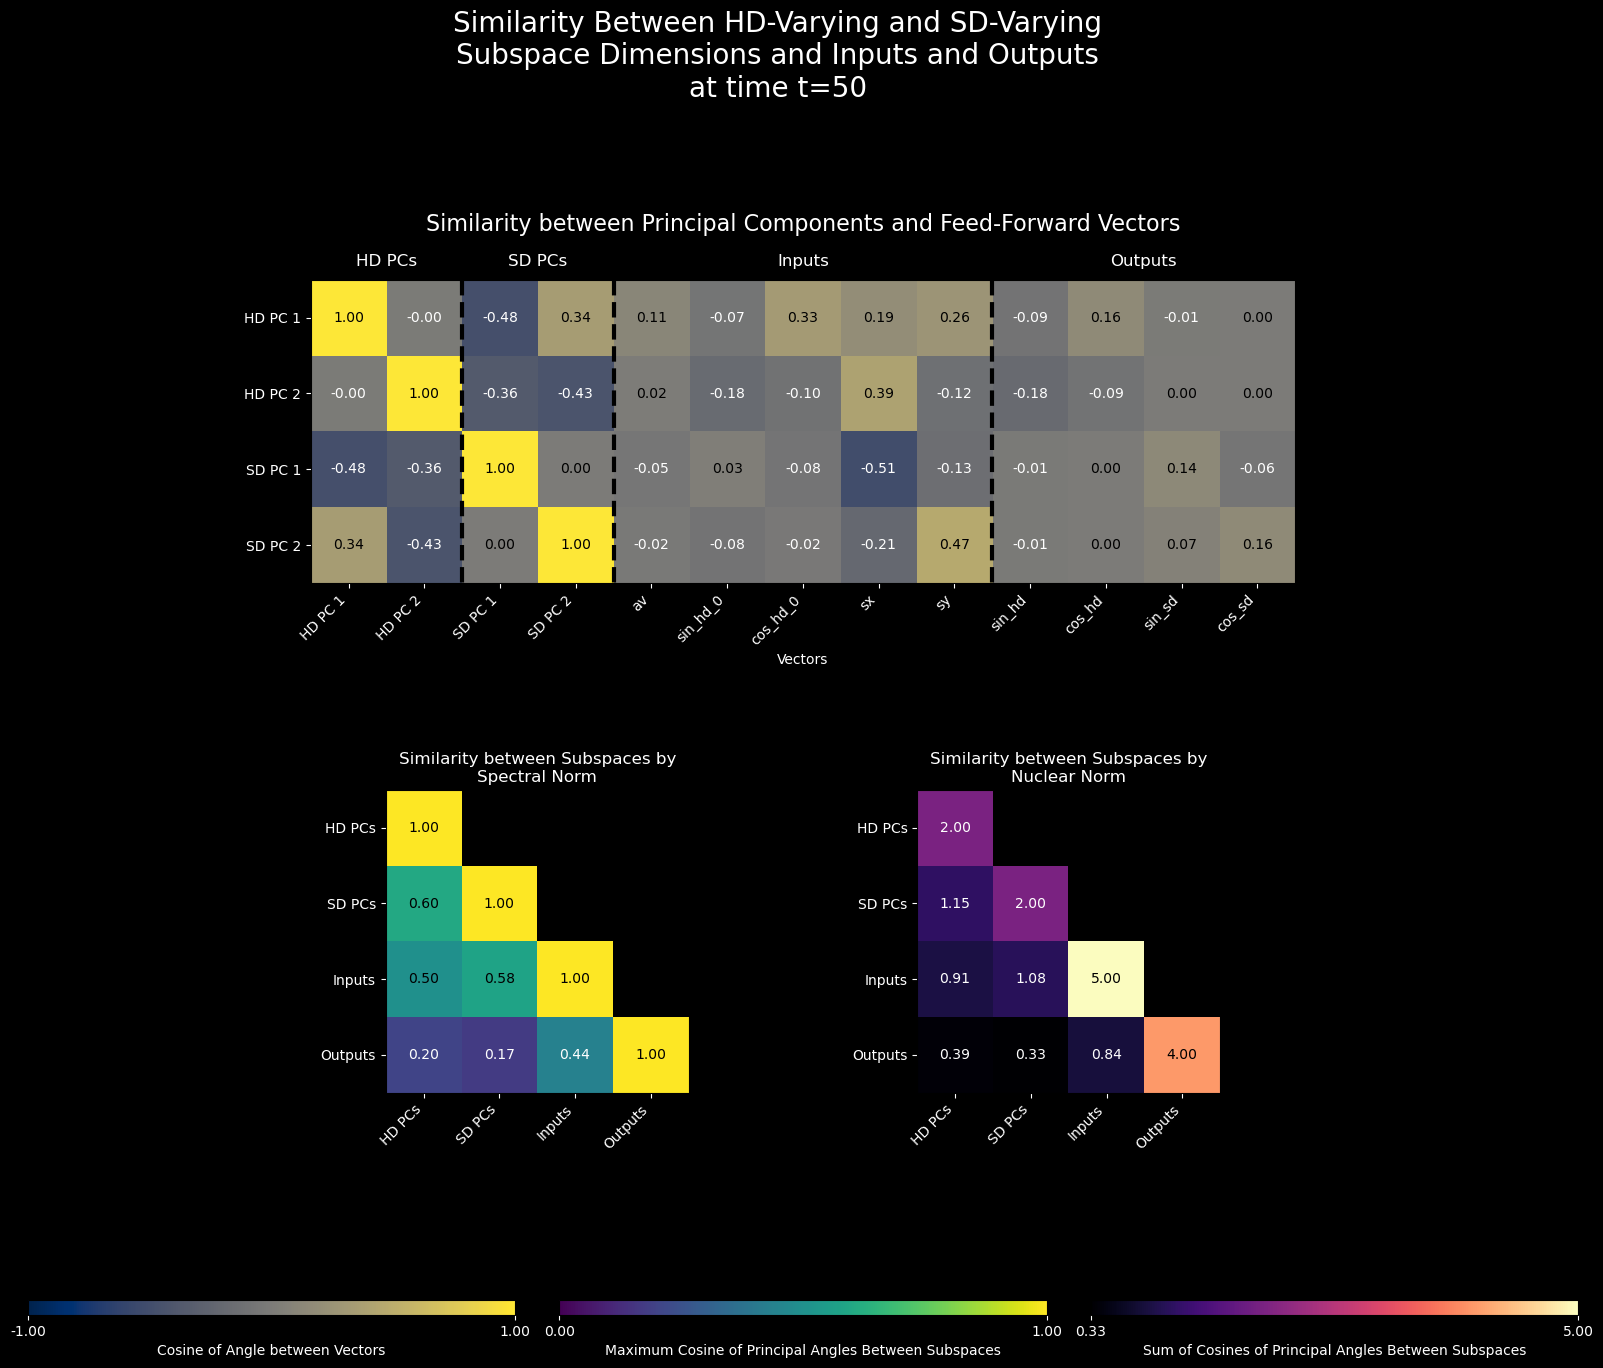

In [9]:


"""
Plot vector-wise and subspace-wise similarity between head-direction varying and shelter-direction varying subspaces, and model inputs and outputs.
"""

inverse_target_map = {}
for k,v in hd_iso_task.target_map.items():
    inverse_target_map[v]=k
inverse_input_map = {}
for k,v in hd_iso_task.input_map.items():
    inverse_input_map[v]=k


fig = plt.figure(figsize=(20,15))
gs = fig.add_gridspec(3, 6, height_ratios=[1,1,0.05], hspace=1)


sim_cmap = matplotlib.colormaps['cividis']
sim_norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)

vector_sim_ax = fig.add_subplot(gs[0,:])

im1 = vector_sim_ax.imshow(pc_sim, interpolation='nearest', cmap=sim_cmap, norm=sim_norm)
vector_sim_ax.set_title('Similarity between Principal Components and Feed-Forward Vectors', pad=35, fontsize=16)
vector_sim_ax.set_xlabel('Vectors')
vector_sim_ax.set_xticks([i for i in range(4 + net.n_inputs + net.n_outputs)])
vector_sim_ax.set_xticklabels(['HD PC 1', 'HD PC 2', 'SD PC 1', 'SD PC 2'] + [inverse_input_map[i] for i in range(net.n_inputs)] + [inverse_target_map[i] for i in range(net.n_outputs)], rotation=45, ha='right')
vector_sim_ax.set_yticks([0,1,2,3])
vector_sim_ax.set_yticklabels(['HD PC 1', 'HD PC 2', 'SD PC 1', 'SD PC 2'])

for i in range(pc_sim.shape[0]):
    for j in range(pc_sim.shape[1]):
        vector_sim_ax.text(j, i, f"{pc_sim[i, j]:.2f}", ha="center", va="center", color="white" if im1.norm(pc_sim[i, j]) < 0.5 else "black")

groups = ['HD PCs', 'SD PCs', 'Inputs', 'Outputs']
group_sizes = np.array([2, 2, net.n_inputs, net.n_outputs])
group_starts = np.cumsum(group_sizes)
vector_sim_ax.vlines(group_starts[:-1]-0.5, ymin=-0.5, ymax=3.5, color='black', linewidth=3, linestyle='--')
for i, group in enumerate(groups):
    vector_sim_ax.text(group_starts[i] - group_sizes[i]/2 - 0.5, -0.75, group, ha='center', va='center', fontsize=12)


spectral_sim_ax = fig.add_subplot(gs[1,1:3])

spectral_cmap = matplotlib.colormaps['viridis']
spectral_norm = matplotlib.colors.Normalize(vmin=0, vmax=1)

im2 = spectral_sim_ax.imshow(spectral_sim, interpolation='nearest', cmap=spectral_cmap, norm=spectral_norm)
spectral_sim_ax.set_title('Similarity between Subspaces by\nSpectral Norm')
spectral_sim_ax.set_xticks([0,1,2,3])
spectral_sim_ax.set_xticklabels(['HD PCs', 'SD PCs', 'Inputs', 'Outputs'], rotation=45, ha='right')
spectral_sim_ax.set_yticks([0,1,2,3])
spectral_sim_ax.set_yticklabels(['HD PCs', 'SD PCs', 'Inputs', 'Outputs'])

for i in range(spectral_sim.shape[0]):
    for j in range(spectral_sim.shape[1]):
        spectral_sim_ax.text(j, i, f"{spectral_sim[i, j]:.2f}", ha="center", va="center", color="white" if im2.norm(spectral_sim[i, j]) < 0.5 else "black")



nuclear_sim_ax = fig.add_subplot(gs[1,3:5])

nuclear_cmap = matplotlib.colormaps['magma']
nuclear_norm = matplotlib.colors.Normalize(vmin=np.nanmin(nuclear_sim), vmax=np.nanmax(nuclear_sim))

im3 = nuclear_sim_ax.imshow(nuclear_sim, interpolation='nearest', cmap=nuclear_cmap, norm=nuclear_norm)
nuclear_sim_ax.set_title('Similarity between Subspaces by\nNuclear Norm')
nuclear_sim_ax.set_xticks([0,1,2,3])
nuclear_sim_ax.set_xticklabels(['HD PCs', 'SD PCs', 'Inputs', 'Outputs'], rotation=45, ha='right')
nuclear_sim_ax.set_yticks([0,1,2,3])
nuclear_sim_ax.set_yticklabels(['HD PCs', 'SD PCs', 'Inputs', 'Outputs'])

for i in range(nuclear_sim.shape[0]):
    for j in range(nuclear_sim.shape[1]):
        nuclear_sim_ax.text(j, i, f"{nuclear_sim[i, j]:.2f}", ha="center", va="center", color="white" if im3.norm(nuclear_sim[i, j]) < 0.5 else "black")


cax1 = fig.add_subplot(gs[2,0:2])
cbar1 = fig.colorbar(im1, ax=vector_sim_ax, cax=cax1, orientation='horizontal', fraction=0.02, pad=0.1)
cbar1.set_label('Cosine of Angle between Vectors')
cbar1.set_ticks([sim_norm.vmin, sim_norm.vmax])
cbar1.set_ticklabels([f"{sim_norm.vmin:.2f}", f"{sim_norm.vmax:.2f}"])

cax2 = fig.add_subplot(gs[2,2:4])
cbar2 = fig.colorbar(im2, ax=spectral_sim_ax, cax=cax2, orientation='horizontal', fraction=0.02, pad=0.1)
cbar2.set_label("Maximum Cosine of Principal Angles Between Subspaces")
cbar2.set_ticks([spectral_norm.vmin, spectral_norm.vmax])
cbar2.set_ticklabels([f"{spectral_norm.vmin:.2f}", f"{spectral_norm.vmax:.2f}"])

cax3 = fig.add_subplot(gs[2,4:6])
cbar3 = fig.colorbar(im3, ax=nuclear_sim_ax, cax=cax3, orientation='horizontal', fraction=0.02, pad=0.1)
cbar3.set_label("Sum of Cosines of Principal Angles Between Subspaces")
cbar3.set_ticks([nuclear_norm.vmin, nuclear_norm.vmax])
cbar3.set_ticklabels([f"{nuclear_norm.vmin:.2f}", f"{nuclear_norm.vmax:.2f}"])

fig.suptitle(f'Similarity Between HD-Varying and SD-Varying\nSubspace Dimensions and Inputs and Outputs\nat time t={eval_t}', fontsize=20)
fig.subplots_adjust(top=0.8)

plt.show()

## Time Variance in Subspace Similarity

In [13]:






def get_iso_subspace_variance_across_time(max_dim=5):
    
    
    assert hd_iso_task.config.n_timesteps == sd_iso_task.config.n_timesteps
    n_timesteps = hd_iso_task.config.n_timesteps

    hd_dim_variance = np.full((max_dim, n_timesteps), fill_value=np.nan)
    sd_dim_variance = np.full((max_dim, n_timesteps), fill_value=np.nan)

    hd_batch = TaskDataset(hd_iso_task).get_batch()
    sd_batch = TaskDataset(sd_iso_task).get_batch()
    hd_activity = net(hd_batch['inputs'], noise=hd_batch['noise'])[1].detach().numpy() 
    sd_activity = net(sd_batch['inputs'], noise=sd_batch['noise'])[1].detach().numpy()

    for t in range(n_timesteps):
        hd_pca, sd_pca = get_iso_subspaces_at_time(t, max_components=max_dim, activity=(hd_activity, sd_activity))[2:4]

        hd_dim_variance[:,t] = np.cumsum(hd_pca.explained_variance_ratio_)
        sd_dim_variance[:,t] = np.cumsum(sd_pca.explained_variance_ratio_)

    return hd_dim_variance, sd_dim_variance

def get_iso_subspace_self_similarity_across_time(dim=2):
    assert hd_iso_task.config.n_timesteps == sd_iso_task.config.n_timesteps
    n_timesteps = hd_iso_task.config.n_timesteps

    hd_spectral_norms = np.full((n_timesteps, n_timesteps), fill_value=np.nan)
    sd_spectral_norms = np.full((n_timesteps, n_timesteps), fill_value=np.nan)

    hd_batch = TaskDataset(hd_iso_task).get_batch()
    sd_batch = TaskDataset(sd_iso_task).get_batch()
    hd_activity = net(hd_batch['inputs'], noise=hd_batch['noise'])[1].detach().numpy() 
    sd_activity = net(sd_batch['inputs'], noise=sd_batch['noise'])[1].detach().numpy()

    for i in range(n_timesteps):
        hd_pca_i, sd_pca_i = get_iso_subspaces_at_time(i, max_components=dim, activity=(hd_activity, sd_activity))[2:4]
        hd_subspace_i, sd_subspace_i = hd_pca_i.components_.T, sd_pca_i.components_.T

        for j in range(i+1):
            hd_pca_j, sd_pca_j = get_iso_subspaces_at_time(j, max_components=dim, activity=(hd_activity, sd_activity))[2:4]
            hd_subspace_j, sd_subspace_j = hd_pca_j.components_.T, sd_pca_j.components_.T

            hd_spectral_norm = get_norms(hd_subspace_i, hd_subspace_j)[0]
            sd_spectral_norm = get_norms(sd_subspace_i, sd_subspace_j)[0]

            hd_spectral_norms[i, j] = hd_spectral_norm
            sd_spectral_norms[i, j] = sd_spectral_norm

    return hd_spectral_norms, sd_spectral_norms

def get_iso_subspace_similarity_across_time(dim=2):
    assert hd_iso_task.config.n_timesteps == sd_iso_task.config.n_timesteps
    n_timesteps = hd_iso_task.config.n_timesteps

    hd_spectral_norms = np.full((n_timesteps, 3), fill_value=np.nan)
    sd_spectral_norms = np.full((n_timesteps, 3), fill_value=np.nan)

    hd_batch = TaskDataset(hd_iso_task).get_batch()
    sd_batch = TaskDataset(sd_iso_task).get_batch()
    hd_activity = net(hd_batch['inputs'], noise=hd_batch['noise'])[1].detach().numpy() 
    sd_activity = net(sd_batch['inputs'], noise=sd_batch['noise'])[1].detach().numpy()

    for t in range(n_timesteps):

        hd_pca, sd_pca = get_iso_subspaces_at_time(t, max_components=dim, activity=(hd_activity, sd_activity))[2:4]
        hd_t_subspace = hd_pca.components_.T
        sd_t_subspace = sd_pca.components_.T

        hd_vs_win = get_norms(hd_t_subspace, net.W_in.weight.detach().numpy())[0]
        hd_vs_wout = get_norms(hd_t_subspace, net.W_out.weight.detach().T.numpy())[0]
        hd_vs_sd = get_norms(hd_t_subspace, sd_t_subspace)[0]

        sd_vs_win = get_norms(sd_t_subspace, net.W_in.weight.detach().numpy())[0]
        sd_vs_wout = get_norms(sd_t_subspace, net.W_out.weight.detach().T.numpy())[0]
        sd_vs_hd = get_norms(sd_t_subspace, hd_t_subspace)[0]

        assert np.isclose(hd_vs_sd, sd_vs_hd), f"Spectral norm mismatch at timestep {t}: {hd_vs_sd} vs {sd_vs_hd}"

        hd_spectral_norms[t, 0] = hd_vs_win
        hd_spectral_norms[t, 1] = hd_vs_wout
        hd_spectral_norms[t, 2] = hd_vs_sd

        sd_spectral_norms[t, 0] = sd_vs_win
        sd_spectral_norms[t, 1] = sd_vs_wout
        sd_spectral_norms[t, 2] = sd_vs_hd

    return hd_spectral_norms, sd_spectral_norms

In [10]:






def get_iso_subspace_variance_across_time(max_dim=5):
    """
    Calculate the cumulative explained variance of PCA subspaces across time for head-direction (hd) and 
    shelter-direction (sd) tasks.
    Args:
        max_dim (int): The maximum number of principal components to consider for the explained variance.
    Returns:
        tuple: Two numpy arrays of shape (max_dim, n_timesteps) containing the cumulative explained variance ratios 
            for the head-direction and shelter-direction tasks respectively.
    Raises:
        AssertionError: If the number of timesteps in the head-direction task does not match the number of timesteps 
                        in the shelter-direction task.
    """ 
    
    assert hd_iso_task.config.n_timesteps == sd_iso_task.config.n_timesteps
    n_timesteps = hd_iso_task.config.n_timesteps

    hd_dim_variance = np.full((max_dim, n_timesteps), fill_value=np.nan)
    sd_dim_variance = np.full((max_dim, n_timesteps), fill_value=np.nan)

    hd_batch = TaskDataset(hd_iso_task).get_batch()
    sd_batch = TaskDataset(sd_iso_task).get_batch()
    hd_activity = net(hd_batch['inputs'], noise=hd_batch['noise'])[1].detach().numpy() 
    sd_activity = net(sd_batch['inputs'], noise=sd_batch['noise'])[1].detach().numpy()

    for t in range(n_timesteps):
        hd_pca, sd_pca = get_iso_subspaces_at_time(t, max_components=max_dim, activity=(hd_activity, sd_activity))[2:4]

        hd_dim_variance[:,t] = np.cumsum(hd_pca.explained_variance_ratio_)
        sd_dim_variance[:,t] = np.cumsum(sd_pca.explained_variance_ratio_)

    return hd_dim_variance, sd_dim_variance

def get_iso_subspace_self_similarity_across_time(dim=2):
    """
    Calculate the self-similarity of PCA subspaces across time for head-direction (hd) and 
    shelter-direction (sd) tasks using spectral norms.
    dim (int): The number of principal components to consider for the subspaces. Default is 2.
    Args:
        dim (int, optional): The number of principal components to consider for the subspaces. Default is 2.
    Returns:
        tuple: Two numpy arrays (hd_spectral_norms, sd_spectral_norms) containing the spectral norms
    """

    assert hd_iso_task.config.n_timesteps == sd_iso_task.config.n_timesteps
    n_timesteps = hd_iso_task.config.n_timesteps

    hd_spectral_norms = np.full((n_timesteps, n_timesteps), fill_value=np.nan)
    sd_spectral_norms = np.full((n_timesteps, n_timesteps), fill_value=np.nan)

    hd_batch = TaskDataset(hd_iso_task).get_batch()
    sd_batch = TaskDataset(sd_iso_task).get_batch()
    hd_activity = net(hd_batch['inputs'], noise=hd_batch['noise'])[1].detach().numpy() 
    sd_activity = net(sd_batch['inputs'], noise=sd_batch['noise'])[1].detach().numpy()

    for i in range(n_timesteps):
        hd_pca_i, sd_pca_i = get_iso_subspaces_at_time(i, max_components=dim, activity=(hd_activity, sd_activity))[2:4]
        hd_subspace_i, sd_subspace_i = hd_pca_i.components_.T, sd_pca_i.components_.T

        for j in range(i+1):
            hd_pca_j, sd_pca_j = get_iso_subspaces_at_time(j, max_components=dim, activity=(hd_activity, sd_activity))[2:4]
            hd_subspace_j, sd_subspace_j = hd_pca_j.components_.T, sd_pca_j.components_.T

            hd_spectral_norm = get_norms(hd_subspace_i, hd_subspace_j)[0]
            sd_spectral_norm = get_norms(sd_subspace_i, sd_subspace_j)[0]

            hd_spectral_norms[i, j] = hd_spectral_norm
            sd_spectral_norms[i, j] = sd_spectral_norm

    return hd_spectral_norms, sd_spectral_norms

def get_iso_subspace_similarity_across_time(dim=2):
    """
    Calculate the similarity of PCA subspaces across time for head-direction (hd) and shelter-direction (sd) tasks.
    This function computes the spectral norms of the subspaces formed by the principal components of the neural activity
    at each timestep for both hd and sd tasks. It compares these subspaces with the input and output weights of the network
    and with each other.
    Parameters:
        dim (int): The number of principal components to consider for the subspaces. Default is 2.
    Returns:
        tuple: Two numpy arrays containing the spectral norms for hd and sd tasks respectively. Each array has shape 
            (n_timesteps, 3), where the columns correspond to the norms with respect to the input weights, output weights, 
            and the other task's subspace.
    """



    assert hd_iso_task.config.n_timesteps == sd_iso_task.config.n_timesteps
    n_timesteps = hd_iso_task.config.n_timesteps

    hd_spectral_norms = np.full((n_timesteps, 3), fill_value=np.nan)
    sd_spectral_norms = np.full((n_timesteps, 3), fill_value=np.nan)

    hd_batch = TaskDataset(hd_iso_task).get_batch()
    sd_batch = TaskDataset(sd_iso_task).get_batch()
    hd_activity = net(hd_batch['inputs'], noise=hd_batch['noise'])[1].detach().numpy() 
    sd_activity = net(sd_batch['inputs'], noise=sd_batch['noise'])[1].detach().numpy()

    for t in range(n_timesteps):

        hd_pca, sd_pca = get_iso_subspaces_at_time(t, max_components=dim, activity=(hd_activity, sd_activity))[2:4]
        hd_t_subspace = hd_pca.components_.T
        sd_t_subspace = sd_pca.components_.T

        hd_vs_win = get_norms(hd_t_subspace, net.W_in.weight.detach().numpy())[0]
        hd_vs_wout = get_norms(hd_t_subspace, net.W_out.weight.detach().T.numpy())[0]
        hd_vs_sd = get_norms(hd_t_subspace, sd_t_subspace)[0]

        sd_vs_win = get_norms(sd_t_subspace, net.W_in.weight.detach().numpy())[0]
        sd_vs_wout = get_norms(sd_t_subspace, net.W_out.weight.detach().T.numpy())[0]
        sd_vs_hd = get_norms(sd_t_subspace, hd_t_subspace)[0]

        assert np.isclose(hd_vs_sd, sd_vs_hd), f"Spectral norm mismatch at timestep {t}: {hd_vs_sd} vs {sd_vs_hd}"

        hd_spectral_norms[t, 0] = hd_vs_win
        hd_spectral_norms[t, 1] = hd_vs_wout
        hd_spectral_norms[t, 2] = hd_vs_sd

        sd_spectral_norms[t, 0] = sd_vs_win
        sd_spectral_norms[t, 1] = sd_vs_wout
        sd_spectral_norms[t, 2] = sd_vs_hd

    return hd_spectral_norms, sd_spectral_norms

hd_dim_variance, sd_dim_variance = get_iso_subspace_variance_across_time()
hd_self_spectral_norms, sd_self_spectral_norms = get_iso_subspace_self_similarity_across_time()
hd_spectral_norms, sd_spectral_norms = get_iso_subspace_similarity_across_time()

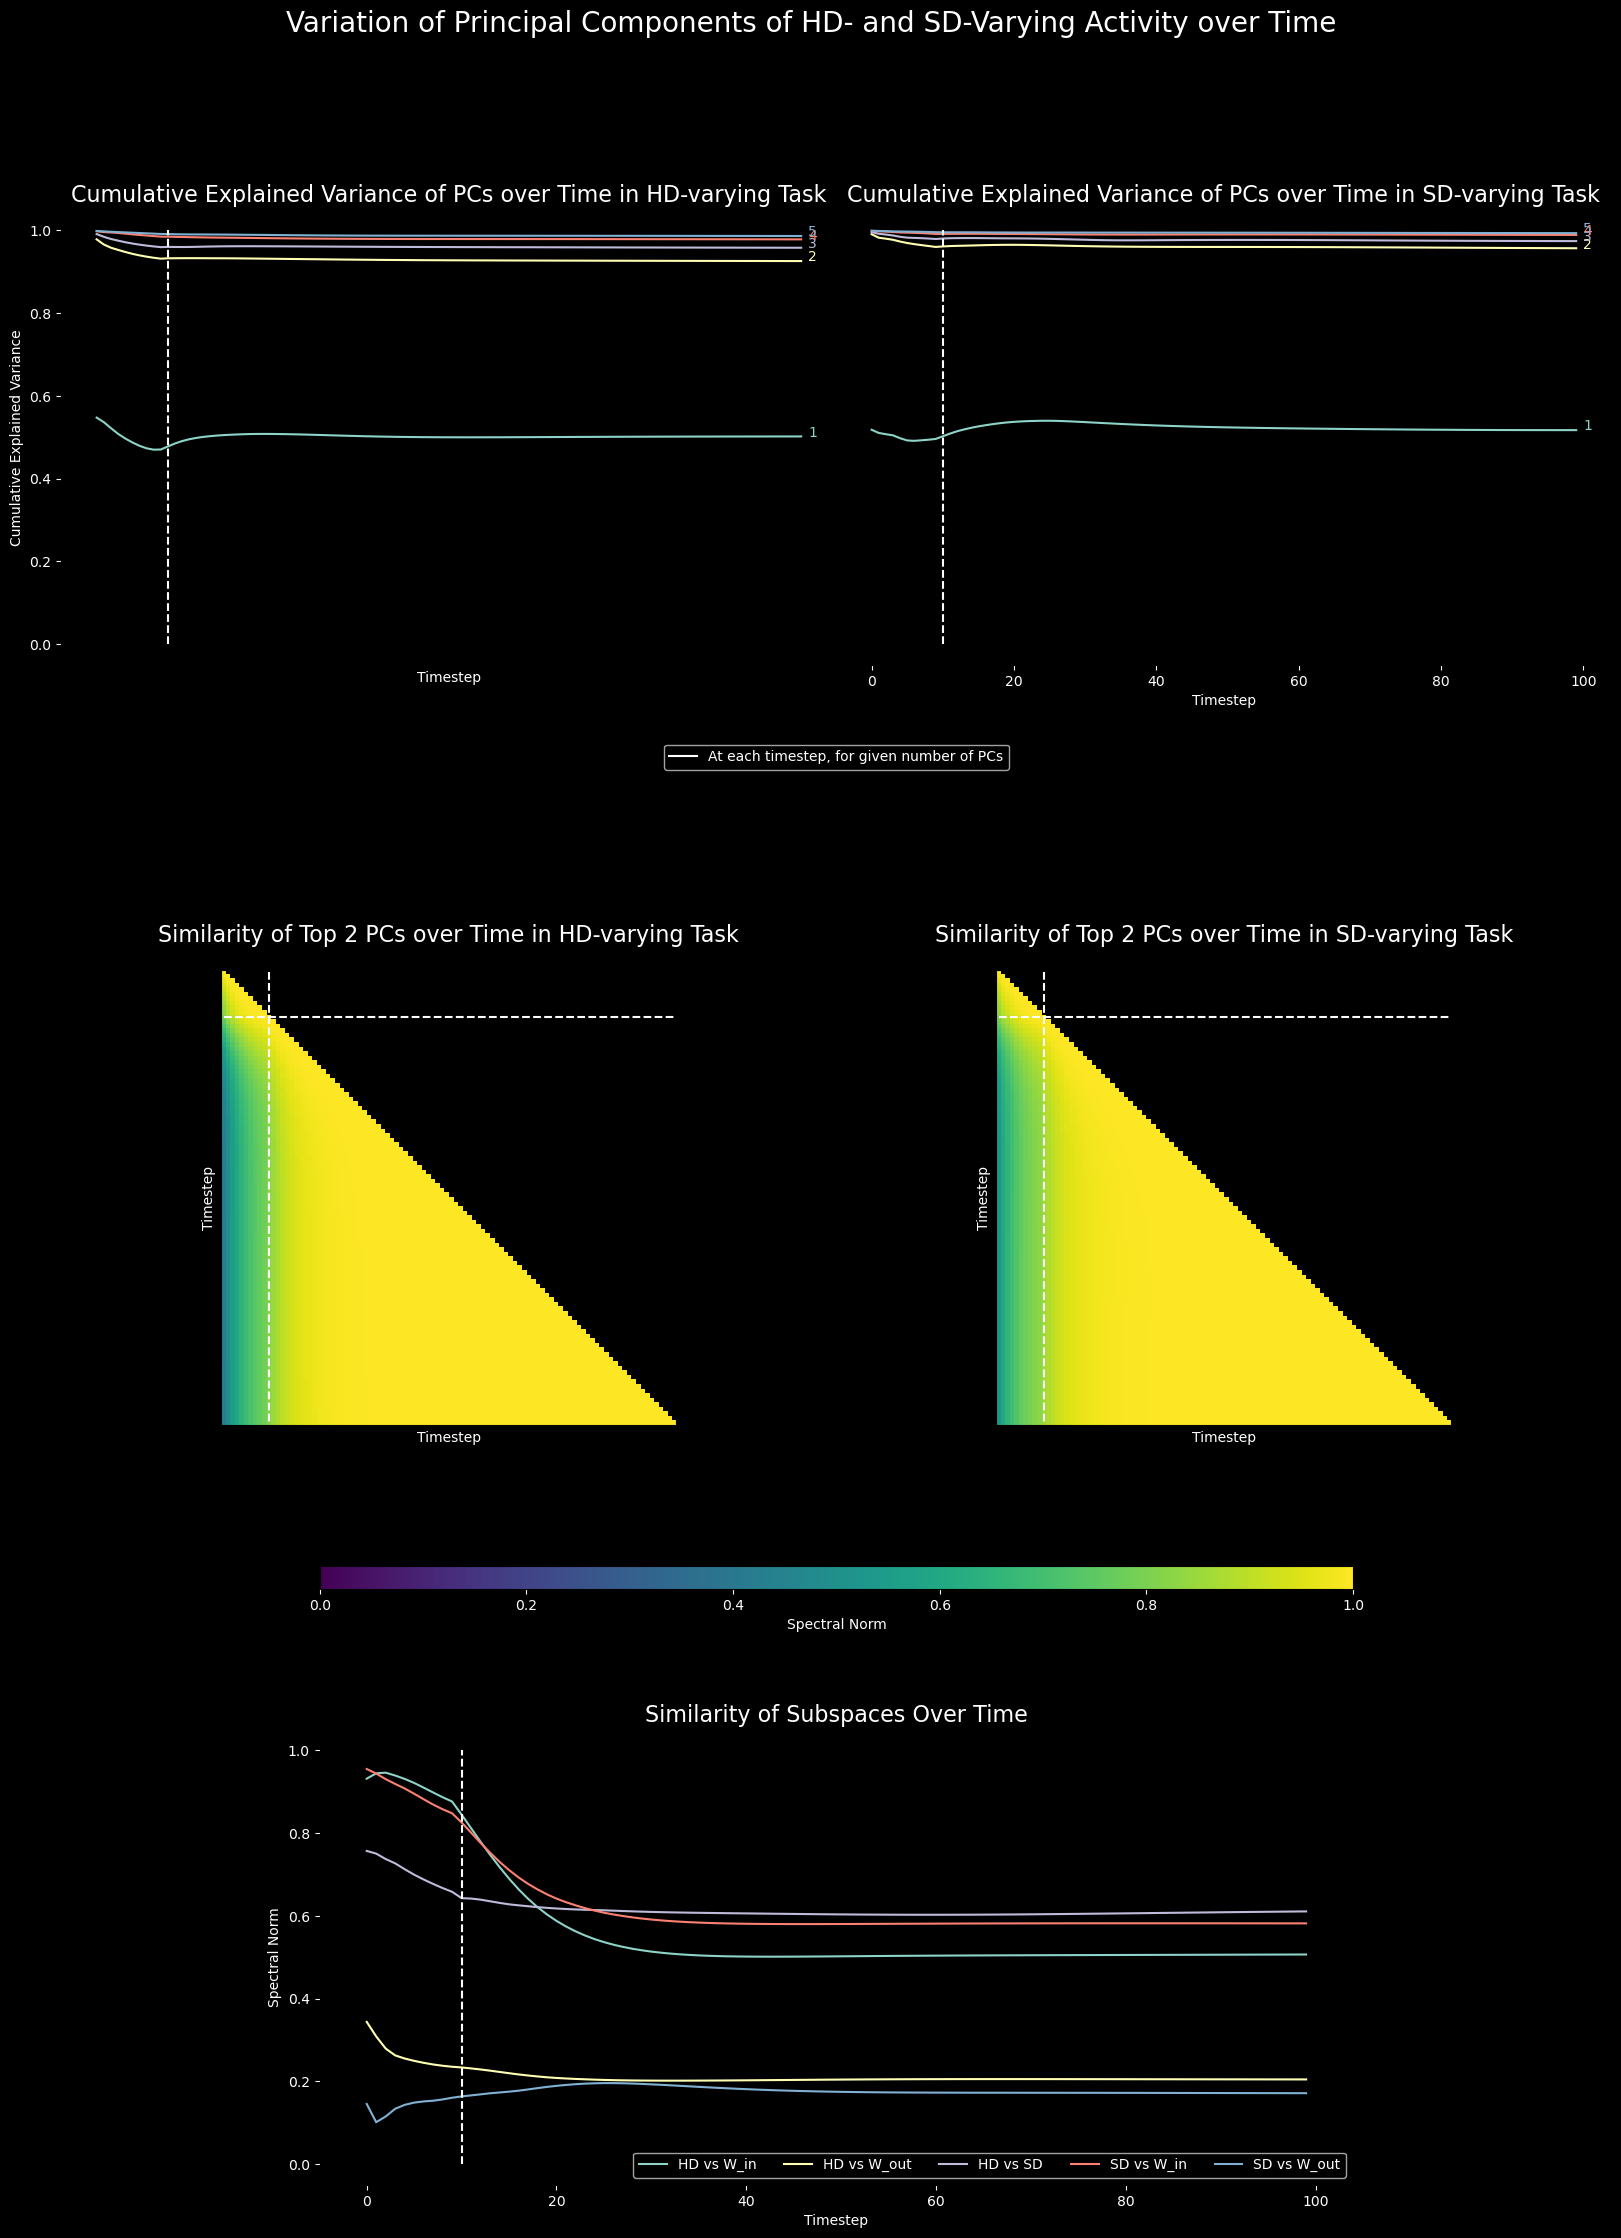

In [11]:




"""
Plot the similarity of PCA subspaces and the cumulative explained variance of the principal components over time.
"""

fig = plt.figure(figsize=(20, 25))
gs = fig.add_gridspec(nrows=5, ncols=6, height_ratios=[1,0.05,1,0.05,1], wspace=0, hspace=0.5)

ax1 = fig.add_subplot(gs[0,0:3])
ax2 = fig.add_subplot(gs[0,3:6])

dim_cmap = matplotlib.colormaps['Set3']

x = np.arange(hd_iso_task.config.n_timesteps)
for i in range(hd_dim_variance.shape[0]):
    ax1.plot(x, hd_dim_variance[i], label=f'{i+1} PC{"s" if i>0 else ""}', color=dim_cmap(i))
    ax1.annotate(f'{i+1}', xy=(hd_iso_task.config.n_timesteps, hd_dim_variance[i, -1]), color=dim_cmap(i)) 

    ax2.plot(x, sd_dim_variance[i], label=f'{i+1} PC{"s" if i>0 else ""}', color=dim_cmap(i))
    ax2.annotate(f'{i+1}', xy=(sd_iso_task.config.n_timesteps, sd_dim_variance[i, -1]), color=dim_cmap(i))

ax1.vlines(x=hd_iso_task.config.init_duration, ymin=0, ymax=1, color='white', linestyle='--')
ax2.vlines(x=sd_iso_task.config.init_duration, ymin=0, ymax=1, color='white', linestyle='--')

ax1.set_xlabel('Timestep')
ax2.set_xlabel('Timestep')
ax1.set_xticks([])
ax1.set_ylabel('Cumulative Explained Variance')
ax2.set_yticks([])
ax1.set_title('Cumulative Explained Variance of PCs over Time in HD-varying Task', fontsize=16)
ax2.set_title('Cumulative Explained Variance of PCs over Time in SD-varying Task', fontsize=16)

cax1 = fig.add_subplot(gs[1,2:4])
solid_line = matplotlib.lines.Line2D([], [], color='white', linestyle='-', label='At each timestep, for given number of PCs')
cax1.legend(handles=[solid_line], loc='upper center', ncol=2, bbox_to_anchor=(0.5, 4))
cax1.set_axis_off()


ax3 = fig.add_subplot(gs[2,0:3])
ax4 = fig.add_subplot(gs[2,3:6])

im1 = ax3.imshow(hd_self_spectral_norms, cmap='viridis', norm=matplotlib.colors.Normalize(vmin=0, vmax=1))
ax3.hlines(y=hd_iso_task.config.init_duration, xmin=0, xmax=hd_iso_task.config.n_timesteps-1, color='white', linestyle='--')
ax3.vlines(x=hd_iso_task.config.init_duration, ymin=0, ymax=hd_iso_task.config.n_timesteps-1, color='white', linestyle='--')

ax3.set_title('Similarity of Top 2 PCs over Time in HD-varying Task', pad=20, fontsize=16)
ax3.set_xlabel('Timestep')
ax3.set_xticks([])
ax3.set_ylabel('Timestep')
ax3.set_yticks([])

im2 = ax4.imshow(sd_self_spectral_norms, cmap='viridis', norm=matplotlib.colors.Normalize(vmin=0, vmax=1))
ax4.hlines(y=sd_iso_task.config.init_duration, xmin=0, xmax=sd_iso_task.config.n_timesteps-1, color='white', linestyle='--')
ax4.vlines(x=sd_iso_task.config.init_duration, ymin=0, ymax=sd_iso_task.config.n_timesteps-1, color='white', linestyle='--')

ax4.set_title('Similarity of Top 2 PCs over Time in SD-varying Task', pad=20, fontsize=16)
ax4.set_xlabel('Timestep')
ax4.set_xticks([])
ax4.set_ylabel('Timestep')
ax4.set_yticks([])

cax2 = fig.add_subplot(gs[3,1:5])
cbar4 = fig.colorbar(im1, ax=[ax3,ax4], cax=cax2, orientation='horizontal')
cbar4.set_label('Spectral Norm')


comp_cmap = matplotlib.colormaps['Set3']

ax5 = fig.add_subplot(gs[4,1:5])

ax5.plot(x, hd_spectral_norms[:, 0], label='HD vs W_in', color=comp_cmap(0))
ax5.plot(x, hd_spectral_norms[:, 1], label='HD vs W_out', color=comp_cmap(1))
ax5.plot(x, hd_spectral_norms[:, 2], label='HD vs SD', color=comp_cmap(2))

ax5.plot(x, sd_spectral_norms[:, 0], label='SD vs W_in', color=comp_cmap(3))
ax5.plot(x, sd_spectral_norms[:, 1], label='SD vs W_out', color=comp_cmap(4))

ax5.vlines(x=hd_iso_task.config.init_duration, ymin=0, ymax=1, color='white', linestyle='--')

ax5.set_xlabel('Timestep')
ax5.set_ylabel('Spectral Norm')
ax5.set_title('Similarity of Subspaces Over Time', fontsize=16)
ax5.legend(ncol=5, loc='lower right')

fig.suptitle('Variation of Principal Components of HD- and SD-Varying Activity over Time', fontsize=20)
fig.subplots_adjust(top=0.9)

plt.show()


## Unfinished

### Split by Initial/Stable Period

In [15]:
def get_iso_subspaces_in_time_period(tmin, tmax, max_components=2):
    assert hd_iso_task.config.n_timesteps == sd_iso_task.config.n_timesteps
    assert tmin < tmax
    assert tmin >= 0 and tmax <= hd_iso_task.config.n_timesteps

    hd_batch = TaskDataset(hd_iso_task).get_batch()
    sd_batch = TaskDataset(sd_iso_task).get_batch()
    hd_activity = net(hd_batch['inputs'], noise=hd_batch['noise'])[1].detach().numpy() 
    sd_activity = net(sd_batch['inputs'], noise=sd_batch['noise'])[1].detach().numpy()

    hd_pca = PCA(n_components=max_components)
    hd_pca_activity = hd_pca.fit_transform(hd_activity[:, tmin:tmax].reshape((-1, net.n_neurons)))
    hd_subspace = hd_pca.components_.T

    sd_pca = PCA(n_components=max_components)
    sd_pca_activity = sd_pca.fit_transform(sd_activity[:, tmin:tmax].reshape((-1, net.n_neurons)))
    sd_subspace = sd_pca.components_.T

    return hd_pca_activity, hd_subspace, sd_pca_activity, sd_subspace


hd_init_pca_activity, hd_init_pca_subspace, sd_init_pca_activity, sd_init_pca_subspace = get_iso_subspaces_in_time_period(0, hd_iso_task.config.init_duration)
hd_stable_pca_activity, hd_stable_pca_subspace, sd_stable_pca_activity, sd_stable_pca_subspace = get_iso_subspaces_in_time_period(hd_iso_task.config.init_duration, hd_iso_task.config.n_timesteps)

hd_delta_subspace = hd_stable_pca_subspace - hd_init_pca_subspace
sd_delta_subspace = sd_stable_pca_subspace - sd_init_pca_subspace


subspaces = [hd_init_pca_subspace, hd_stable_pca_subspace, sd_init_pca_subspace, sd_stable_pca_subspace, hd_delta_subspace, sd_delta_subspace]
comp_subspaces = [hd_init_pca_subspace, hd_stable_pca_subspace, sd_init_pca_subspace, sd_stable_pca_subspace, hd_delta_subspace, sd_delta_subspace, net.W_in.weight.detach().numpy(), net.W_out.weight.detach().T.numpy()]
spectral_norms = np.full((len(subspaces), len(comp_subspaces)), np.nan)

for i in range(len(subspaces)):
    for j in range(len(comp_subspaces)):
        spectral_norms[i, j] = get_norms(subspaces[i], comp_subspaces[j])[0]


In [ ]:

fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.matshow(spectral_norms, cmap='viridis', norm=matplotlib.colors.Normalize(vmin=0, vmax=1))
fig.colorbar(cax, orientation='horizontal')

ax.set_xticks(range(len(comp_subspaces)))
ax.set_yticks(range(len(subspaces)))
ax.set_xticklabels(['HD Initial', 'HD Stable', 'SD Initial', 'SD Stable', 'HD Init->Stable', 'SD Init->Stable', 'W_in', 'W_out'], rotation=45, ha='right')
ax.set_yticklabels(['HD Initial', 'HD Stable', 'SD Initial', 'SD Stable', 'HD Init->Stable', 'SD Init->Stable'])
ax.xaxis.set_label_position('bottom')
ax.xaxis.tick_bottom()

for i in range(len(subspaces)):
    for j in range(len(comp_subspaces)):
        ax.text(j, i, f"{spectral_norms[i, j]:.2f}", ha='center', va='center', color='white' if spectral_norms[i, j] < 0.5 else 'black')

fig.suptitle('Similarity between Time-Split Subspaces', fontsize=22)
plt.show()

### No angular velocity; HD and SD fixed within trial, across [0, 2 $\pi$ ] between trials

In [ ]:
%matplotlib inline

from Tasks.util import register_all_tasks
register_all_tasks()

checkpoint_path = 'trained-models/1737566092.4583075-task:HD_SD-0D-rate_lambda:0.01-weight_lambda:0.01/checkpoint-epochs:72000/net.pt'
checkpoint = torch.load(checkpoint_path, map_location='cpu')
task = Task.from_checkpoint(checkpoint=checkpoint)
task.config.update(device='cpu')
net = RNN(task)
net.load_state_dict(checkpoint['net_state_dict'])

torch.manual_seed(time.time())


def create_2d_systematic_data(config, inputs, targets, mask):
    batch_size, n_timesteps, init_duration = config.batch_size, config.n_timesteps, config.init_duration

    n_steps = int(np.sqrt(batch_size))
    assert batch_size == n_steps**2

    joint_range = torch.meshgrid(torch.linspace(0, 2*np.pi, n_steps), torch.linspace(0, 2*np.pi, n_steps))
    hd_range, sd_range = joint_range[0].flatten(), joint_range[1].flatten()

    head_direction = hd_range.reshape((batch_size, 1)).repeat((1, n_timesteps))
    ego_shelter_angle = sd_range.reshape((batch_size, 1)).repeat((1, n_timesteps))

    allo_shelter_angle = torch.remainder(head_direction + ego_shelter_angle, 2*np.pi)[:,0].reshape((batch_size,1))

    vars = {'av': torch.zeros((batch_size, n_timesteps)), 
            'hd': head_direction, 
            'sd': ego_shelter_angle,
            'sx': torch.cos(allo_shelter_angle), 
            'sy': torch.sin(allo_shelter_angle)}
    
    inputs[:,:,Tasks.vars_0D.input_map['av']] = vars['av']
    inputs[:,:init_duration,Tasks.vars_0D.input_map['sin_hd_0']] = torch.sin(vars['hd'][:,0]).reshape((batch_size,1)).repeat((1,init_duration))
    inputs[:,:init_duration,Tasks.vars_0D.input_map['cos_hd_0']] = torch.cos(vars['hd'][:,0]).reshape((batch_size,1)).repeat((1,init_duration))
    inputs[:,:init_duration,Tasks.vars_0D.input_map['sx']] = vars['sx'].repeat((1,init_duration))
    inputs[:,:init_duration,Tasks.vars_0D.input_map['sy']] = vars['sy'].repeat((1,init_duration))

    mask[:,:init_duration] = False

    targets[:,:,Tasks.HD_SD_0D.target_map['sin_hd']] = torch.sin(vars['hd'])
    targets[:,:,Tasks.HD_SD_0D.target_map['cos_hd']] = torch.cos(vars['hd'])
    targets[:,:,Tasks.HD_SD_0D.target_map['sin_sd']] = torch.sin(vars['sd'])
    targets[:,:,Tasks.HD_SD_0D.target_map['cos_sd']] = torch.cos(vars['sd'])

    return inputs, targets, vars, mask

test_task = Task.named('HD_SD-0D', create_data_func=create_2d_systematic_data)
test_task.config.update(batch_size=10000, n_timesteps=100, state_noise_std=0)

test_batch = TaskDataset(test_task).get_batch()
_,test_activity,test_outputs = net(test_batch['inputs'], noise=test_batch['noise'])
test_activity, test_outputs = test_activity.detach().numpy(), test_outputs.detach().numpy()

eval_t = test_task.config.init_duration

test_pca = PCA(n_components=10)
test_pca_activity = test_pca.fit_transform(test_activity[:,eval_t].reshape((-1,100)))

print(f'Joint HD-SD-varying task, prop. var. in top {test_pca.n_components_} PCs: {np.sum(test_pca.explained_variance_ratio_).item()}')


In [ ]:
fig, ax = plt.subplots(nrows=10, ncols=10, figsize=(25,20), sharex=True, sharey=True)

indices = np.random.permutation(10000)[:100]

hd_cmap = matplotlib.colormaps['Blues']
sd_cmap = matplotlib.colormaps['Oranges']

handles = {}

for i in range(10):
    for j in range(10):
        k = indices[i*10+j]
        hd_true, = ax[i,j].plot(test_batch['vars']['hd'][k], color=hd_cmap(0.8), label='True Head Direction')

        sd_true, = ax[i,j].plot(test_batch['vars']['sd'][k], color=sd_cmap(0.8), label='True Shelter Direction')

        hd = np.arctan2(test_outputs[k,:,test_task.target_map['sin_hd']], test_outputs[k,:,test_task.target_map['cos_hd']])
        hd[hd<0] += 2*np.pi
        hd_pred, = ax[i,j].plot(hd, color=hd_cmap(0.8), label='Model Head Direction', linestyle='--')

        sd = np.arctan2(test_outputs[k,:,test_task.target_map['sin_sd']], test_outputs[k,:,test_task.target_map['cos_sd']])
        sd[sd<0] += 2*np.pi
        sd_pred, = ax[i,j].plot(sd, color=sd_cmap(0.8), label='Model Shelter Direction', linestyle='--')

        handles['hd_true'], handles['sd_true'], handles['hd_pred'], handles['sd_pred'] = hd_true, sd_true, hd_pred, sd_pred

        if i == 9:
            ax[i,j].set_xlim([0, 100])
            ax[i,j].set_xticks([0, 10, 100])
            ax[i,j].set_xlabel('Timestep')
        if j == 0:
            ax[i,j].set_ylim([0, 2*np.pi])
            ax[i,j].set_yticks([0, 2*np.pi])
            ax[i,j].set_ylabel('Angle')

fig.legend(handles=handles.values(), ncols=4, loc='lower center')
fig.suptitle('Example Model Response', fontweight='bold', fontsize=22)

plt.show()

In [ ]:
cmap = matplotlib.colormaps['Greens']
hd_cmap = matplotlib.colormaps['Blues']
sd_cmap = matplotlib.colormaps['Oranges']
norm = matplotlib.colors.Normalize(vmin=0, vmax=2*np.pi)

fig = plt.figure(figsize=(20,20))
outer_gs = fig.add_gridspec(nrows=3, ncols=2, height_ratios=[1,1,0.05])

dim_subfig = fig.add_subfigure(outer_gs[0,:])
dim_subfig.suptitle('Dimensionality of Model Response (in Principal Components)', fontsize=22, fontweight='bold')

dim_ax = dim_subfig.add_subplot(111)

x = 1 + np.arange(test_pca.n_components_, dtype=int)
dim_ax.bar(x, test_pca.explained_variance_ratio_, color=cmap(0.8))

dim_ax.set_xlim([0.5, test_pca.n_components_ + 1])
dim_ax.set_xticks(x)
dim_ax.set_xticklabels([f"PC {i+1}" for i in range(test_pca.n_components_)])
dim_ax.set_xlabel("Principal Components")
dim_ax.set_ylabel("Explained Variance Ratio")



hd_ring_subfig = fig.add_subfigure(outer_gs[1,0])
hd_ring_subfig.suptitle('PC Manifold Activity - Head Direction', fontsize=22, fontweight='bold')
hd_ring_ax = hd_ring_subfig.subplots(nrows=3, ncols=3, sharex=True, sharey=True)

sd_ring_subfig = fig.add_subfigure(outer_gs[1,1])
sd_ring_subfig.suptitle('PC Manifold Activity - Shelter Direction', fontsize=22, fontweight='bold')
sd_ring_ax = sd_ring_subfig.subplots(nrows=3, ncols=3, sharex=True, sharey=True)

for i in range(3):
    for j in range(3):
        if j > i:
            hd_ring_ax[i,j].set_axis_off()
            sd_ring_ax[i,j].set_axis_off()
            continue

        x_pc = j
        y_pc = i+1

        hd_ring_plot = hd_ring_ax[i,j].scatter(test_pca_activity[:,x_pc], test_pca_activity[:,y_pc], c=test_batch['vars']['hd'][:,eval_t], cmap=hd_cmap, norm=norm)
        sd_ring_plot = sd_ring_ax[i,j].scatter(test_pca_activity[:,x_pc], test_pca_activity[:,y_pc], c=test_batch['vars']['sd'][:,eval_t], cmap=sd_cmap, norm=norm)

        if i == 2:
            hd_ring_ax[i,j].set_xlabel(f'PC {x_pc+1}')
            hd_ring_ax[i,j].set_xticks([])

            sd_ring_ax[i,j].set_xlabel(f'PC {x_pc+1}')
            sd_ring_ax[i,j].set_xticks([])
        if j == 0:  
            hd_ring_ax[i,j].set_ylabel(f'PC {y_pc+1}')
            hd_ring_ax[i,j].set_yticks([])

            sd_ring_ax[i,j].set_ylabel(f'PC {y_pc+1}')
            sd_ring_ax[i,j].set_yticks([])


cbar_subfig = fig.add_subfigure(outer_gs[2,:])
cax = cbar_subfig.subplots(ncols=2)

cbar1 = fig.colorbar(hd_ring_plot, cax=cax[0], orientation='horizontal', fraction=0.02, pad=0.1)
cbar1.set_label('Head Direction (HD)')

cbar2 = fig.colorbar(sd_ring_plot, cax=cax[1], orientation='horizontal', fraction=0.02, pad=0.1)
cbar2.set_label('Shelter Direction (SD)')


plt.show()

In [ ]:
in_subspace = net.W_in.weight.detach().numpy()
out_subspace = net.W_out.weight.detach().T.numpy()

def get_norms(M_A, M_B):
    Q_A, R_A = np.linalg.qr(M_A, mode='reduced')
    Q_B, R_B = np.linalg.qr(M_B, mode='reduced')

    # 2. Form the r x r product Q_A^T Q_B
    Q_A_t_Q_B = Q_A.T @ Q_B

    # 3. Get singular values of Q_A^T Q_B
    svals = np.linalg.svd(Q_A_t_Q_B, full_matrices=False, compute_uv=False)


    # Spectral norm = largest singular value
    spectral_norm = svals.max()  # or svals[0], as they are returned in descending order

    # Nuclear norm = sum of singular values
    nuclear_norm = svals.sum()

    return spectral_norm, nuclear_norm

def get_subspace_similarity():
    spectral_sim = np.full((5, 5), fill_value=np.nan)
    nuclear_sim = np.full((5, 5), fill_value=np.nan)
    
    _, _, hd_iso_pca, sd_iso_pca, _, _ = get_iso_subspaces_at_time(eval_t, max_components=2)
    hd_subspace = np.stack([hd_iso_pca.components_[0], hd_iso_pca.components_[1]], axis=0).T
    sd_subspace = np.stack([sd_iso_pca.components_[0], sd_iso_pca.components_[1]], axis=0).T
    joint_subspace = np.stack([test_pca.components_[i] for i in range(4)], axis=0).T

    subspaces = [joint_subspace, hd_subspace, sd_subspace, in_subspace, out_subspace]

    for i in range(5):
        for j in range(i, 5):
            spectral_norm, nuclear_norm = get_norms(subspaces[i], subspaces[j])
            spectral_sim[i,j] = spectral_norm
            nuclear_sim[i,j] = nuclear_norm

    return spectral_sim, nuclear_sim, subspaces

spectral_sim, nuclear_sim, subspaces = get_subspace_similarity()



fig = plt.figure(figsize=(15,15))
gs = fig.add_gridspec(nrows=3, ncols=2, height_ratios=[1,1,0.05], hspace=0.5)

spectral_sim_ax = fig.add_subplot(gs[0,0])

spectral_cmap = matplotlib.colormaps['viridis']
spectral_norm = matplotlib.colors.Normalize(vmin=0, vmax=1)

im1 = spectral_sim_ax.imshow(spectral_sim, interpolation='nearest', cmap=spectral_cmap, norm=spectral_norm)
spectral_sim_ax.set_title('Similarity between Subspaces by Spectral Norm')
spectral_sim_ax.set_xticks([0,1,2,3,4])
spectral_sim_ax.set_xticklabels(['Joint PCs', 'HD PCs', 'SD PCs', 'Inputs', 'Outputs'], rotation=45, ha='right')
spectral_sim_ax.set_yticks([0,1,2,3,4])
spectral_sim_ax.set_yticklabels(['Joint PCs', 'HD PCs', 'SD PCs', 'Inputs', 'Outputs'])

for i in range(spectral_sim.shape[0]):
    for j in range(spectral_sim.shape[1]):
        spectral_sim_ax.text(j, i, f"{spectral_sim[i, j]:.2f}", ha="center", va="center", color="white" if im1.norm(spectral_sim[i, j]) < 0.5 else "black")



nuclear_sim_ax = fig.add_subplot(gs[0,1])

nuclear_cmap = matplotlib.colormaps['magma']
nuclear_norm = matplotlib.colors.Normalize(vmin=np.nanmin(nuclear_sim), vmax=np.nanmax(nuclear_sim))

im2 = nuclear_sim_ax.imshow(nuclear_sim, interpolation='nearest', cmap=nuclear_cmap, norm=nuclear_norm)
nuclear_sim_ax.set_title('Similarity between Subspaces by Nuclear Norm')
nuclear_sim_ax.set_xticks([0,1,2,3,4])
nuclear_sim_ax.set_xticklabels(['Joint PCs', 'HD PCs', 'SD PCs', 'Inputs', 'Outputs'], rotation=45, ha='right')
nuclear_sim_ax.set_yticks([0,1,2,3,4])
nuclear_sim_ax.set_yticklabels(['Joint PCs', 'HD PCs', 'SD PCs', 'Inputs', 'Outputs'])

for i in range(nuclear_sim.shape[0]):
    for j in range(nuclear_sim.shape[1]):
        nuclear_sim_ax.text(j, i, f"{nuclear_sim[i, j]:.2f}", ha="center", va="center", color="white" if im2.norm(nuclear_sim[i, j]) < 0.5 else "black")



vector_sim_ax = fig.add_subplot(gs[1,:])

joint_vectors = subspaces[0].T
comp_vectors = np.concatenate([subspaces[i].T for i in range(1, 5)], axis=0)

joint_vectors = joint_vectors / np.linalg.norm(joint_vectors, axis=1, keepdims=True)
comp_vectors = comp_vectors / np.linalg.norm(comp_vectors, axis=1, keepdims=True)
vector_sim = joint_vectors @ comp_vectors.T


vector_cmap = matplotlib.colormaps['cividis']
vector_norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)

inverse_target_map = {}
for k,v in hd_iso_task.target_map.items():
    inverse_target_map[v]=k
inverse_input_map = {}
for k,v in hd_iso_task.input_map.items():
    inverse_input_map[v]=k

im3 = vector_sim_ax.imshow(vector_sim, interpolation='nearest', cmap=vector_cmap, norm=vector_norm)
vector_sim_ax.set_title('Similarity between Subspaces by Vector', pad=20)
vector_sim_ax.set_yticks([0,1,2,3])
vector_sim_ax.set_yticklabels(['PC 1', 'PC 2', 'PC 3', 'PC 4'])
vector_sim_ax.set_ylabel('Joint Subspace')

xticks = ['PC 1', 'PC 2', 'PC 1', 'PC 2'] + [inverse_input_map[i] for i in range(len(inverse_input_map))] + [inverse_target_map[i] for i in range(len(inverse_target_map))]
xtick_labels = ['HD PCs', 'HD PCs', 'SD PCs', 'SD PCs'] + ['Inputs'] * len(inverse_input_map) + ['Outputs'] * len(inverse_target_map)
vector_sim_ax.set_xticks(list(range(len(xticks))))
vector_sim_ax.set_xticklabels(xticks, rotation=45, ha='right')

grouping_sizes = [2, 2, len(inverse_input_map), len(inverse_target_map)]
group_i = 0
for i, label in enumerate(xtick_labels):
    if i == 0 or label != xtick_labels[i-1]:
        x_offset = grouping_sizes[group_i]/2 - 0.5
        vector_sim_ax.text(i+x_offset, -0.6, label, ha='center', va='center')
        group_i += 1
vector_sim_ax.vlines(x=np.cumsum(np.array(grouping_sizes))-0.5, ymin=-0.5, ymax=3.5, color='black', linestyle='--', linewidth=3)

for i in range(vector_sim.shape[0]):
    for j in range(vector_sim.shape[1]):
        vector_sim_ax.text(j, i, f"{vector_sim[i, j]:.2f}", ha="center", va="center", color="white" if im3.norm(vector_sim[i, j]) < 0.3 else "black")




cbar_subfig = fig.add_subfigure(gs[2,:])

cax1 = cbar_subfig.add_subplot(131)
cbar1 = fig.colorbar(im1, ax=spectral_sim_ax, cax=cax1, orientation='horizontal', fraction=0.02, pad=0.05)
cbar1.set_label("Spectral Norm of Diagonalized Matrix of\nSingular Values (of Product of Orthonormal Bases)")
cbar1.set_ticks([spectral_norm.vmin, spectral_norm.vmax])

cax2 = cbar_subfig.add_subplot(132)
cbar2 = fig.colorbar(im2, ax=nuclear_sim_ax, cax=cax2, orientation='horizontal', fraction=0.02, pad=0.05)
cbar2.set_label("Nuclear Norm of Diagonalized Matrix of\nSingular Values (of Product of Orthonormal Bases)")
cbar2.set_ticks([nuclear_norm.vmin, nuclear_norm.vmax])

cax3 = cbar_subfig.add_subplot(133)
cbar3 = fig.colorbar(im3, ax=vector_sim_ax, cax=cax3, orientation='horizontal', fraction=0.02, pad=0.05)
cbar3.set_label("Cosine Similarity Between Vectors")
cbar3.set_ticks([vector_norm.vmin, vector_norm.vmax])

fig.suptitle('Similarity Between Joint and Singly HD- and SD-Varying PCs\nand Input and Output Subspaces', fontweight='bold', fontsize=22)
fig.subplots_adjust(top=0.9)

plt.show()


### Analysis of HD-SD Subspaces Through Time

In [142]:
dim_variance = np.full((10, test_task.config.n_timesteps), fill_value=np.nan)

for t in range(test_task.config.n_timesteps):
    pca = PCA(n_components=10)
    pca_activity = pca.fit_transform(test_activity[:,t].reshape((-1,100)))
    dim_variance[:pca.n_components_,t] = np.cumsum(pca.explained_variance_ratio_)

pca_total = PCA(n_components=10)
pca_total.fit(test_activity.reshape((-1, 100)))
total_variance = np.cumsum(pca_total.explained_variance_ratio_)

spectral_norms = np.full((test_task.config.n_timesteps, test_task.config.n_timesteps), fill_value=np.nan)

for i in range(test_task.config.n_timesteps):
    pca_i = PCA(n_components=4)
    pca_i_activity = pca_i.fit_transform(test_activity[:,i].reshape((-1,100)))
    subspace_i = pca_i.components_.T

    for j in range(i+1):
        pca_j = PCA(n_components=4)
        pca_j_activity = pca_j.fit_transform(test_activity[:,j].reshape((-1,100)))
        subspace_j = pca_j.components_.T

        Q_i, _ = np.linalg.qr(subspace_i, mode='reduced')
        Q_j, _ = np.linalg.qr(subspace_j, mode='reduced')

        Q_i_t_Q_j = Q_i.T @ Q_j
        svals = np.linalg.svd(Q_i_t_Q_j, full_matrices=False, compute_uv=False)

        spectral_norms[i, j] = svals.max()

In [ ]:
fig = plt.figure(figsize=(25, 12))
gs = fig.add_gridspec(nrows=2, ncols=2, height_ratios=[1,0.05], width_ratios=[1, 0.5], wspace=0.3, hspace=0.3)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])

cmap = matplotlib.colormaps['Set3']

x = np.arange(test_task.config.n_timesteps)
for i in range(10):
    ax1.plot(x, dim_variance[i], label=f'{i+1} PC{"s" if i>0 else ""}', color=cmap(i))
    ax1.annotate(f'{i+1}', xy=(test_task.config.n_timesteps, dim_variance[i, -1]), color=cmap(i)) 
    ax1.annotate(f'{i+1}', xy=(-2, total_variance[i]), color=cmap(i)) 
    ax1.hlines(y=total_variance[i], xmin=0, xmax=test_task.config.n_timesteps-2, color=cmap(i), linestyle='--')
ax1.vlines(x=test_task.config.init_duration, ymin=0, ymax=1, color='white', linestyle='--')

ax1.set_xlabel('Timestep')
ax1.set_ylabel('Cumulative Explained Variance')
ax1.set_title('Cumulative Explained Variance of PCs over Time (in Joint HD-SD Varying Task)')
ax1.set_xticks([])

im = ax2.imshow(spectral_norms, cmap='viridis', norm=matplotlib.colors.Normalize(vmin=0, vmax=1))
ax2.hlines(y=test_task.config.init_duration, xmin=0, xmax=test_task.config.n_timesteps-1, color='white', linestyle='--')
ax2.vlines(x=test_task.config.init_duration, ymin=0, ymax=test_task.config.n_timesteps-1, color='white', linestyle='--')

cax = fig.add_subplot(gs[1,1])
cbar = fig.colorbar(im, ax=ax2, cax=cax, orientation='horizontal')
cbar.set_label('Spectral Norm')

ax2.set_title('Similarity of Top Four PCs over Time', pad=20)
ax2.set_xlabel('Timestep')
ax2.set_xticks([])
ax2.set_ylabel('Timestep')
ax2.set_yticks([])

cax = fig.add_subplot(gs[1,0])
solid_line = matplotlib.lines.Line2D([], [], color='white', linestyle='-', label='At each timestep')
dashed_line = matplotlib.lines.Line2D([], [], color='white', linestyle='--', label='At all timesteps')
cax.legend(handles=[solid_line, dashed_line], loc='upper center', ncol=2, bbox_to_anchor=(0.5, -0.15))
cax.set_axis_off()

plt.show()


### Analysis of HD-SD-AV Joint Subspace Through Time

In [ ]:
def create_3d_systematic_data(config, inputs, targets, mask):
    batch_size, n_timesteps, init_duration = config.batch_size, config.n_timesteps, config.init_duration

    n_steps = int(np.sqrt(batch_size))
    assert batch_size == n_steps**2
    assert (n_timesteps-init_duration) % 5 == 0

    joint_range = torch.meshgrid(torch.linspace(0, 2*np.pi, n_steps), torch.linspace(0, 2*np.pi, n_steps))
    hd_range, sd_range = joint_range[0].flatten(), joint_range[1].flatten()

    head_direction = hd_range.reshape((batch_size, 1)).repeat((1, n_timesteps))
    ego_shelter_angle = sd_range.reshape((batch_size, 1)).repeat((1, n_timesteps))
    allo_shelter_angle = torch.remainder(head_direction + ego_shelter_angle, 2*np.pi)[:,0].reshape((batch_size,1))

    period_duration = (n_timesteps-init_duration) // 5
    timestep_av = 2*np.pi / period_duration
    angular_velocity = torch.concatenate((
        torch.zeros((batch_size, init_duration)), torch.zeros((batch_size, period_duration)), timestep_av * torch.ones((batch_size, period_duration)), torch.zeros((batch_size, period_duration)), -timestep_av * torch.ones((batch_size, period_duration)), torch.zeros((batch_size, period_duration))
    ), dim=1)

    vars = {'av': angular_velocity, 
            'hd': head_direction, 
            'sd': ego_shelter_angle,
            'sx': torch.cos(allo_shelter_angle), 
            'sy': torch.sin(allo_shelter_angle)}
    
    inputs[:,:,Tasks.vars_0D.input_map['av']] = vars['av']
    inputs[:,:init_duration,Tasks.vars_0D.input_map['sin_hd_0']] = torch.sin(vars['hd'][:,0]).reshape((batch_size,1)).repeat((1,init_duration))
    inputs[:,:init_duration,Tasks.vars_0D.input_map['cos_hd_0']] = torch.cos(vars['hd'][:,0]).reshape((batch_size,1)).repeat((1,init_duration))
    inputs[:,:init_duration,Tasks.vars_0D.input_map['sx']] = vars['sx'].repeat((1,init_duration))
    inputs[:,:init_duration,Tasks.vars_0D.input_map['sy']] = vars['sy'].repeat((1,init_duration))

    mask[:,:init_duration] = False

    targets[:,:,Tasks.HD_SD_0D.target_map['sin_hd']] = torch.sin(vars['hd'])
    targets[:,:,Tasks.HD_SD_0D.target_map['cos_hd']] = torch.cos(vars['hd'])
    targets[:,:,Tasks.HD_SD_0D.target_map['sin_sd']] = torch.sin(vars['sd'])
    targets[:,:,Tasks.HD_SD_0D.target_map['cos_sd']] = torch.cos(vars['sd'])

    return inputs, targets, vars, mask

time_task = Task.named('HD_SD-0D', create_data_func=create_3d_systematic_data)
time_task.config.update(batch_size=10000, n_timesteps=510, state_noise_std=0)

time_batch = TaskDataset(time_task).get_batch()
_,time_activity,time_outputs = net(time_batch['inputs'], noise=time_batch['noise'])
time_activity, time_outputs = time_activity.detach().numpy(), time_outputs.detach().numpy()

time_pca = PCA(n_components=10)
time_pca_activity = time_pca.fit_transform(test_activity.reshape((-1,100)))

print(f'Angular velocity varying task, prop. var. in top {time_pca.n_components_} PCs: {np.sum(time_pca.explained_variance_ratio_).item()}')


In [ ]:
import umap
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

test_umap = Pipeline([
    ("scaler", StandardScaler()),
    ("umap_reducer", umap.UMAP(
        n_components=4, 
        n_neighbors=15,
        random_state=0,
        verbose=True
    ))
])

test_umap_activity = test_umap.fit_transform(test_activity[:,eval_t].reshape((-1,100)))

fig = plt.figure(figsize=(15,10))
outer_gs = fig.add_gridspec(nrows=2, ncols=2, height_ratios=[1,0.05])

hd_ring_subfig = fig.add_subfigure(outer_gs[0,0])
hd_ring_ax = hd_ring_subfig.subplots(nrows=3, ncols=3, sharex=True, sharey=True)

sd_ring_subfig = fig.add_subfigure(outer_gs[0,1])
sd_ring_ax = sd_ring_subfig.subplots(nrows=3, ncols=3, sharex=True, sharey=True)

for i in range(3):
    for j in range(3):
        if j > i:
            hd_ring_ax[i,j].set_axis_off()
            sd_ring_ax[i,j].set_axis_off()
            continue

        x_pc = j
        y_pc = i+1

        hd_ring_plot = hd_ring_ax[i,j].scatter(test_umap_activity[:,x_pc], test_umap_activity[:,y_pc], c=test_batch['vars']['hd'][:,eval_t], cmap=hd_cmap, norm=norm)
        sd_ring_plot = sd_ring_ax[i,j].scatter(test_umap_activity[:,x_pc], test_umap_activity[:,y_pc], c=test_batch['vars']['sd'][:,eval_t], cmap=sd_cmap, norm=norm)

        hd_ring_ax[i,j].set_aspect("equal", adjustable="box")
        sd_ring_ax[i,j].set_aspect("equal", adjustable="box")
        if i == 2:
            hd_ring_ax[i,j].set_xlabel(f'Dim {x_pc+1}')
            hd_ring_ax[i,j].set_xticks([])

            sd_ring_ax[i,j].set_xlabel(f'Dim {x_pc+1}')
            sd_ring_ax[i,j].set_xticks([])
        if j == 0:  
            hd_ring_ax[i,j].set_ylabel(f'Dim {y_pc+1}')
            hd_ring_ax[i,j].set_yticks([])

            sd_ring_ax[i,j].set_ylabel(f'Dim {y_pc+1}')
            sd_ring_ax[i,j].set_yticks([])


cbar_subfig = fig.add_subfigure(outer_gs[1,:])
cax = cbar_subfig.subplots(ncols=2)

cbar1 = fig.colorbar(hd_ring_plot, cax=cax[0], orientation='horizontal', fraction=0.02, pad=0.1)
cbar1.set_label('Head Direction (HD)')

cbar2 = fig.colorbar(sd_ring_plot, cax=cax[1], orientation='horizontal', fraction=0.02, pad=0.1)
cbar2.set_label('Shelter Direction (SD)')

fig.suptitle('UMAP Manifold Activity', fontsize=22, fontweight='bold')

plt.show()


In [12]:
%matplotlib inline

In [ ]:
# import umap
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler

# test_umap = Pipeline([
#     ("scaler", StandardScaler()),
#     ("umap_reducer", umap.UMAP(
#         n_components=4, 
#         n_neighbors=15,
#         random_state=0,
#         verbose=True
#     ))
# ])

# test_umap_activity = test_umap.fit_transform(test_activity[:,eval_t].reshape((-1,100)))

hd_cmap = matplotlib.colormaps['Blues']
sd_cmap = matplotlib.colormaps['Oranges']
ad_cmap = matplotlib.colormaps['Greens']
norm = matplotlib.colors.Normalize(vmin=0, vmax=2*np.pi)

fig, ax = plt.subplots(ncols=3, figsize=(15,10), subplot_kw=dict(projection='3d'))

ad = torch.remainder(test_batch['vars']['hd'][:,eval_t] + test_batch['vars']['sd'][:,eval_t], 2*np.pi)

ax[0].scatter(xs=test_umap_activity[:,0], ys=test_umap_activity[:,1], zs=test_umap_activity[:,2], c=test_batch['vars']['hd'][:,eval_t], cmap=hd_cmap, norm=norm)
ax[1].scatter(xs=test_umap_activity[:,0], ys=test_umap_activity[:,1], zs=test_umap_activity[:,2], c=test_batch['vars']['sd'][:,eval_t], cmap=sd_cmap, norm=norm)
ax[2].scatter(xs=test_umap_activity[:,0], ys=test_umap_activity[:,1], zs=test_umap_activity[:,2], c=ad, cmap=ad_cmap, norm=norm)


In [ ]:
from sklearn.metrics import mean_squared_error

# umap_results = np.full((10,), fill_value=np.nan)

for d in range(4, 10):
    umapper = Pipeline([
        ("scaler", StandardScaler()),
        ("umap_reducer", umap.UMAP(
            n_components=d+1, 
            n_neighbors=15,
            random_state=0,
            verbose=True
        ))
    ])
    activity = test_activity[:,eval_t].reshape((-1,100))
    activity_down = umapper.fit_transform(activity)
    activity_up = umapper.inverse_transform(activity_down, verbose=True)

    mse = mean_squared_error(activity, activity_up)
    umap_results[d] = mse
    print(f'Completed d={d+1} with mse {mse}')

In [ ]:
task.input_map

## 1D Generalisation Test

In [12]:



checkpoint_path = 'trained-models/1737879839.1750934-task:PI_HD_SD-1D_vecvel-weight_lambda:0.01-optimiser_name:HF-rate_lambda:0.01-max_lr:0.1/checkpoint-loss:0.02/net.pt'

checkpoint = torch.load(checkpoint_path, map_location='cpu')
task = Task.from_checkpoint(checkpoint=checkpoint)
task.config.update(device='cpu', batch_size=2500, state_noise_std=0, n_timesteps=100)
net = RNN(task)
net.load_state_dict(checkpoint['net_state_dict'])
batch = TaskDataset(task, for_training=False).get_batch()

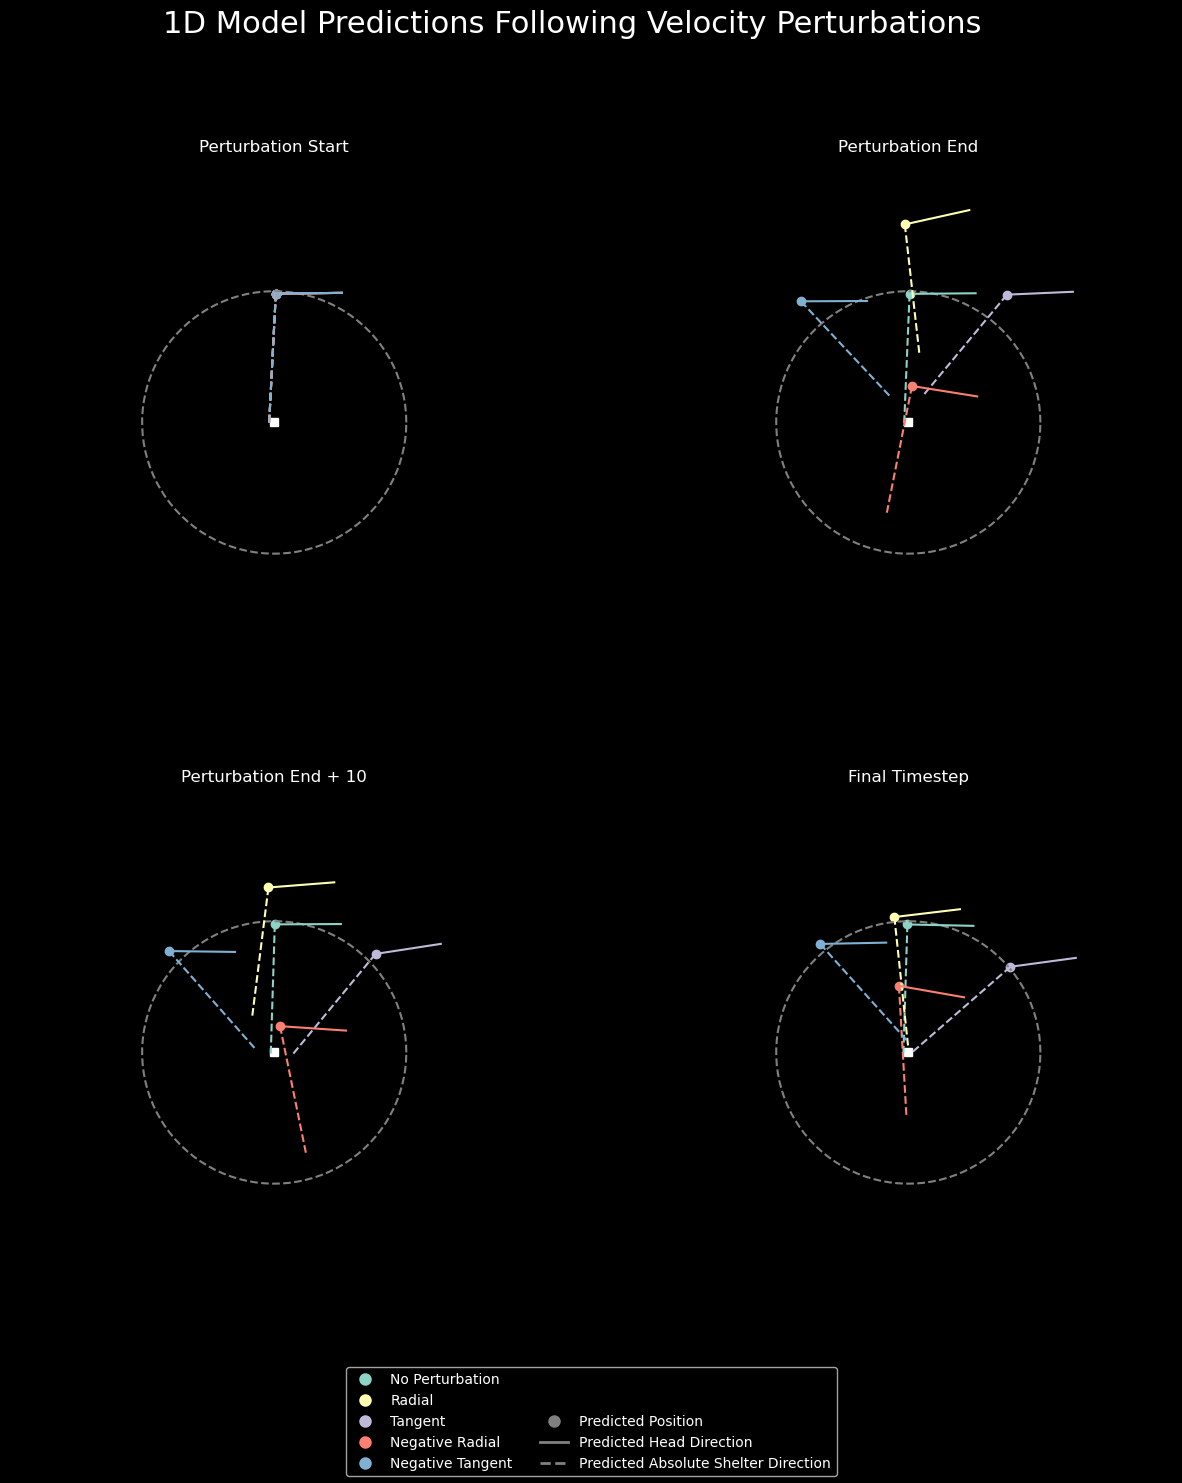

In [16]:
"""
Plot results of knocking 1D mouse in four directions: radially toward and away from shelter, and tangentially forward (i.e. in head direction) and backward
"""

n_trials = 5
trial_labels = ['No Perturbation', 'Radial', 'Tangent', 'Negative Radial', 'Negative Tangent']
initial_hd = torch.zeros((n_trials, 1))
initial_x = np.pi/2 * torch.ones((n_trials, 1))

inputs = torch.zeros((n_trials, task.config.n_timesteps, task.config.n_inputs))
inputs[:,:task.config.init_duration,task.input_map['sin_hd_0']] = torch.sin(initial_hd).repeat((1,task.config.init_duration))
inputs[:,:task.config.init_duration,task.input_map['cos_hd_0']] = torch.cos(initial_hd).repeat((1,task.config.init_duration))
inputs[:,:task.config.init_duration,task.input_map['sin_x_0']] = torch.sin(initial_x).repeat((1,task.config.init_duration))
inputs[:,:task.config.init_duration,task.input_map['cos_x_0']] = torch.cos(initial_x).repeat((1,task.config.init_duration))

move_start_t, move_end_t = 50, 55
move_v = 0.2
total_dist = (move_end_t - move_start_t) * move_v

inputs[1,move_start_t:move_end_t,task.input_map['yv']] = move_v
inputs[2,move_start_t:move_end_t,task.input_map['xv']] = move_v
inputs[3,move_start_t:move_end_t,task.input_map['yv']] = -move_v
inputs[4,move_start_t:move_end_t,task.input_map['xv']] = -move_v

with torch.no_grad():
    outputs = net(inputs)[2]

fig, axs = plt.subplots(2, 2, figsize=(15, 15))
time_points = [move_start_t-1, move_end_t-1, move_end_t + 10, task.config.n_timesteps - 1]
titles = ['Perturbation Start', 'Perturbation End', 'Perturbation End + 10', 'Final Timestep']
colors = matplotlib.colormaps['Set3'](np.arange(n_trials))

for ax, t, title in zip(axs.flatten(), time_points, titles):
    ax.set_axis_off()
    ax.set_xlim([-2, 2])
    ax.set_ylim([-2, 2])
    ax.plot(np.cos(np.linspace(0, 2 * np.pi, 100)), np.sin(np.linspace(0, 2 * np.pi, 100)), color='gray', linestyle='--')
    ax.plot(0, 0, 'ws')  # White square at the origin
    ax.set_title(title)
    
    for trial in range(n_trials):
        x = outputs[trial, t, task.target_map['cos_x']]
        y = outputs[trial, t, task.target_map['sin_x']]
        hd = torch.atan2(outputs[trial, t, task.target_map['sin_hd']], outputs[trial, t, task.target_map['cos_hd']])
        sd = torch.atan2(outputs[trial, t, task.target_map['sin_sd']], outputs[trial, t, task.target_map['cos_sd']])
        ad = hd + sd

        ax.scatter(x, y, label=trial_labels[trial], color=colors[trial])
        ax.plot([x, x + 0.5 * torch.cos(hd)], [y, y + 0.5 * torch.sin(hd)], color=colors[trial])
        ax.plot([x, x + 1 * torch.cos(ad)], [y, y + 1 * torch.sin(ad)], linestyle='--', color=colors[trial])


legend_elements = []
for trial, label in enumerate(trial_labels):
    legend_elements.append(plt.Line2D([0], [0], marker='o', color='black', markerfacecolor=colors[trial], markersize=10, label=label, linestyle='None'))


for _ in range(len(trial_labels) - 3):
    legend_elements.append(plt.Line2D([0], [0], color='none', label=''))

legend_elements.extend([
    plt.Line2D([0], [0], marker='o', color='black', markerfacecolor='gray', markersize=10, label='Predicted Position', linestyle='None'),
    plt.Line2D([0], [0], color='gray', lw=2, label='Predicted Head Direction'),
    plt.Line2D([0], [0], linestyle='--', color='gray', lw=2, label='Predicted Absolute Shelter Direction')
])

fig.legend(handles=legend_elements, loc='lower center', ncol=2)
fig.suptitle('1D Model Predictions Following Velocity Perturbations', fontsize=22)
plt.show()


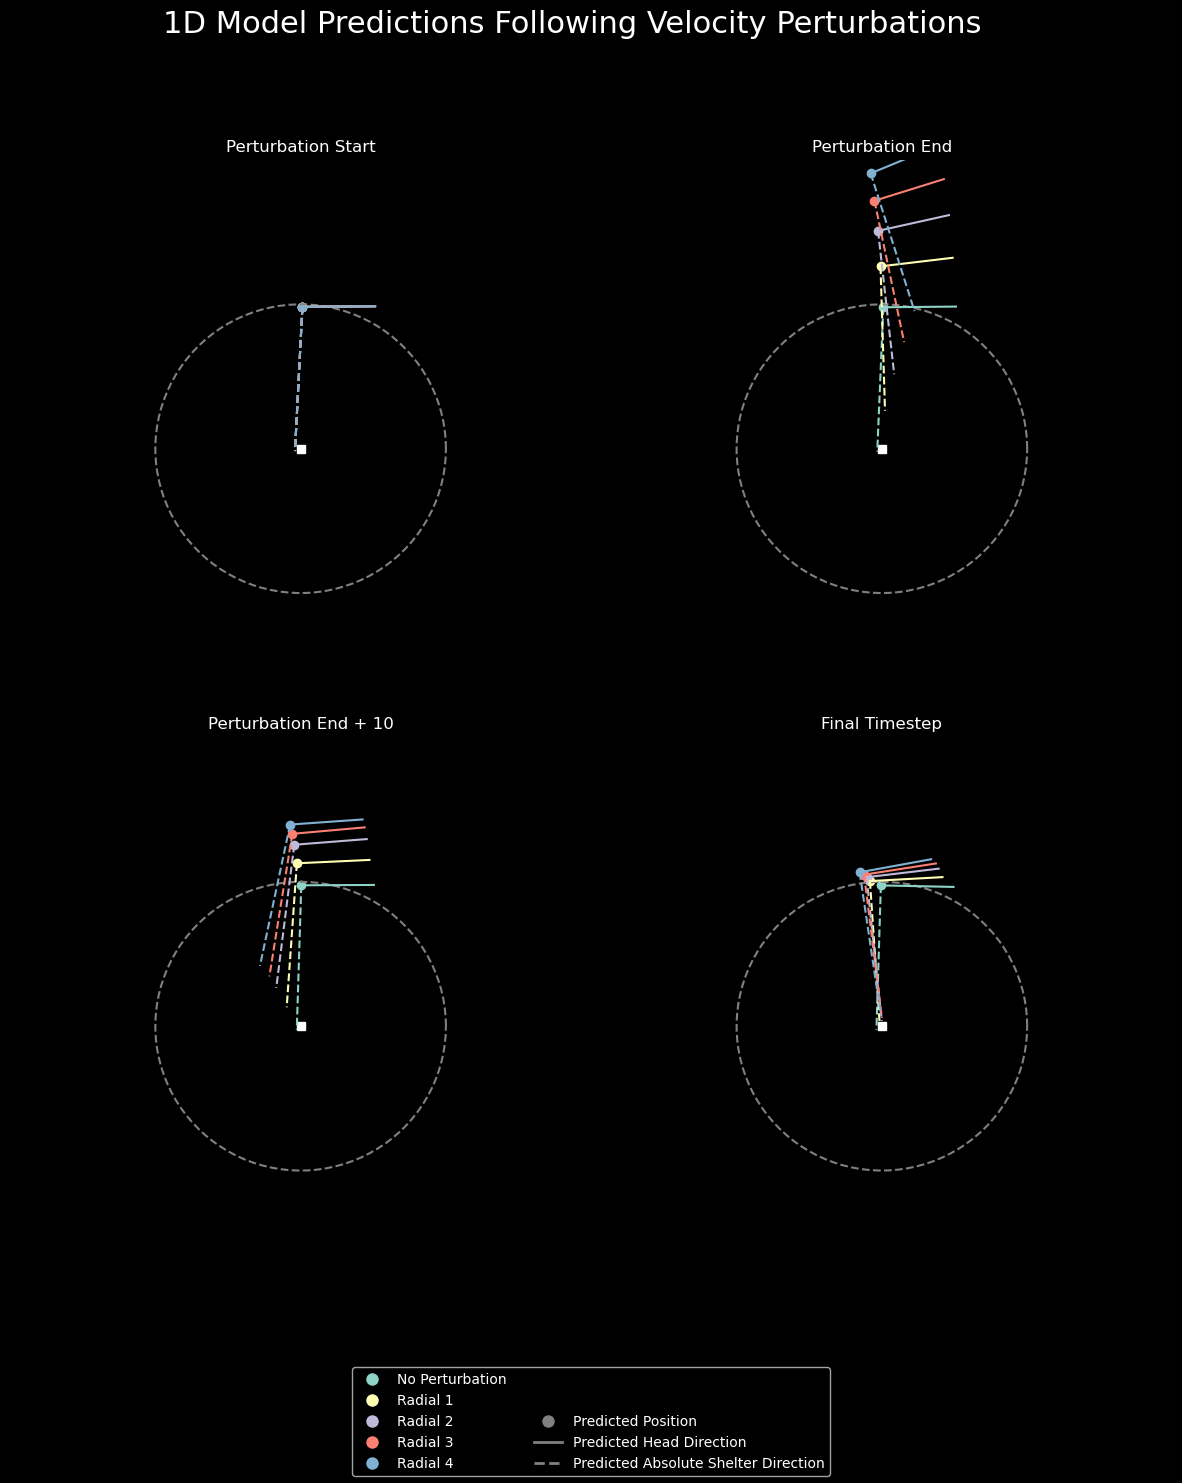

In [14]:
"""
Plot results of knocking 1D mouse radially away from shelter with 4 increasing strengths
"""

n_trials = 5
trial_labels = ['No Perturbation', 'Radial 1', 'Radial 2', 'Radial 3', 'Radial 4']
initial_hd = torch.zeros((n_trials, 1))
initial_x = np.pi/2 * torch.ones((n_trials, 1))

inputs = torch.zeros((n_trials, task.config.n_timesteps, task.config.n_inputs))
inputs[:,:task.config.init_duration,task.input_map['sin_hd_0']] = torch.sin(initial_hd).repeat((1,task.config.init_duration))
inputs[:,:task.config.init_duration,task.input_map['cos_hd_0']] = torch.cos(initial_hd).repeat((1,task.config.init_duration))
inputs[:,:task.config.init_duration,task.input_map['sin_x_0']] = torch.sin(initial_x).repeat((1,task.config.init_duration))
inputs[:,:task.config.init_duration,task.input_map['cos_x_0']] = torch.cos(initial_x).repeat((1,task.config.init_duration))

move_start_t, move_end_t = 50, 55
move_v = 0.1
total_dist = (move_end_t - move_start_t) * move_v

for i in range(1, n_trials):
    inputs[i, move_start_t:move_end_t, task.input_map['yv']] = move_v * i

with torch.no_grad():
    outputs = net(inputs)[2]

fig, axs = plt.subplots(2, 2, figsize=(15, 15), gridspec_kw={'hspace':0, 'wspace':0})
time_points = [move_start_t-1, move_end_t-1, move_end_t + 10, task.config.n_timesteps - 1]
titles = ['Perturbation Start', 'Perturbation End', 'Perturbation End + 10', 'Final Timestep']
colors = matplotlib.colormaps['Set3'](np.arange(n_trials))

for ax, t, title in zip(axs.flatten(), time_points, titles):
    ax.set_axis_off()
    ax.set_xlim([-2, 2])
    ax.set_ylim([-2, 2])
    ax.plot(np.cos(np.linspace(0, 2 * np.pi, 100)), np.sin(np.linspace(0, 2 * np.pi, 100)), color='gray', linestyle='--')
    ax.plot(0, 0, 'ws')  # White square at the origin
    ax.set_title(title)
    
    for trial in range(n_trials):
        x = outputs[trial, t, task.target_map['cos_x']]
        y = outputs[trial, t, task.target_map['sin_x']]
        hd = torch.atan2(outputs[trial, t, task.target_map['sin_hd']], outputs[trial, t, task.target_map['cos_hd']])
        sd = torch.atan2(outputs[trial, t, task.target_map['sin_sd']], outputs[trial, t, task.target_map['cos_sd']])
        ad = hd + sd

        ax.scatter(x, y, label=trial_labels[trial], color=colors[trial])
        ax.plot([x, x + 0.5 * torch.cos(hd)], [y, y + 0.5 * torch.sin(hd)], color=colors[trial])
        ax.plot([x, x + 1 * torch.cos(ad)], [y, y + 1 * torch.sin(ad)], linestyle='--', color=colors[trial])

# Create a legend
legend_elements = []
for trial, label in enumerate(trial_labels):
    legend_elements.append(plt.Line2D([0], [0], marker='o', color='black', markerfacecolor=colors[trial], markersize=10, label=label, linestyle='None'))

# Add dummy elements to ensure the 'predicted' variable elements are in a separate column
for _ in range(len(trial_labels) - 3):
    legend_elements.append(plt.Line2D([0], [0], color='none', label=''))

legend_elements.extend([
    plt.Line2D([0], [0], marker='o', color='black', markerfacecolor='gray', markersize=10, label='Predicted Position', linestyle='None'),
    plt.Line2D([0], [0], color='gray', lw=2, label='Predicted Head Direction'),
    plt.Line2D([0], [0], linestyle='--', color='gray', lw=2, label='Predicted Absolute Shelter Direction')
])

fig.legend(handles=legend_elements, loc='lower center', ncol=2)
fig.suptitle('1D Model Predictions Following Velocity Perturbations', fontsize=22)
plt.show()


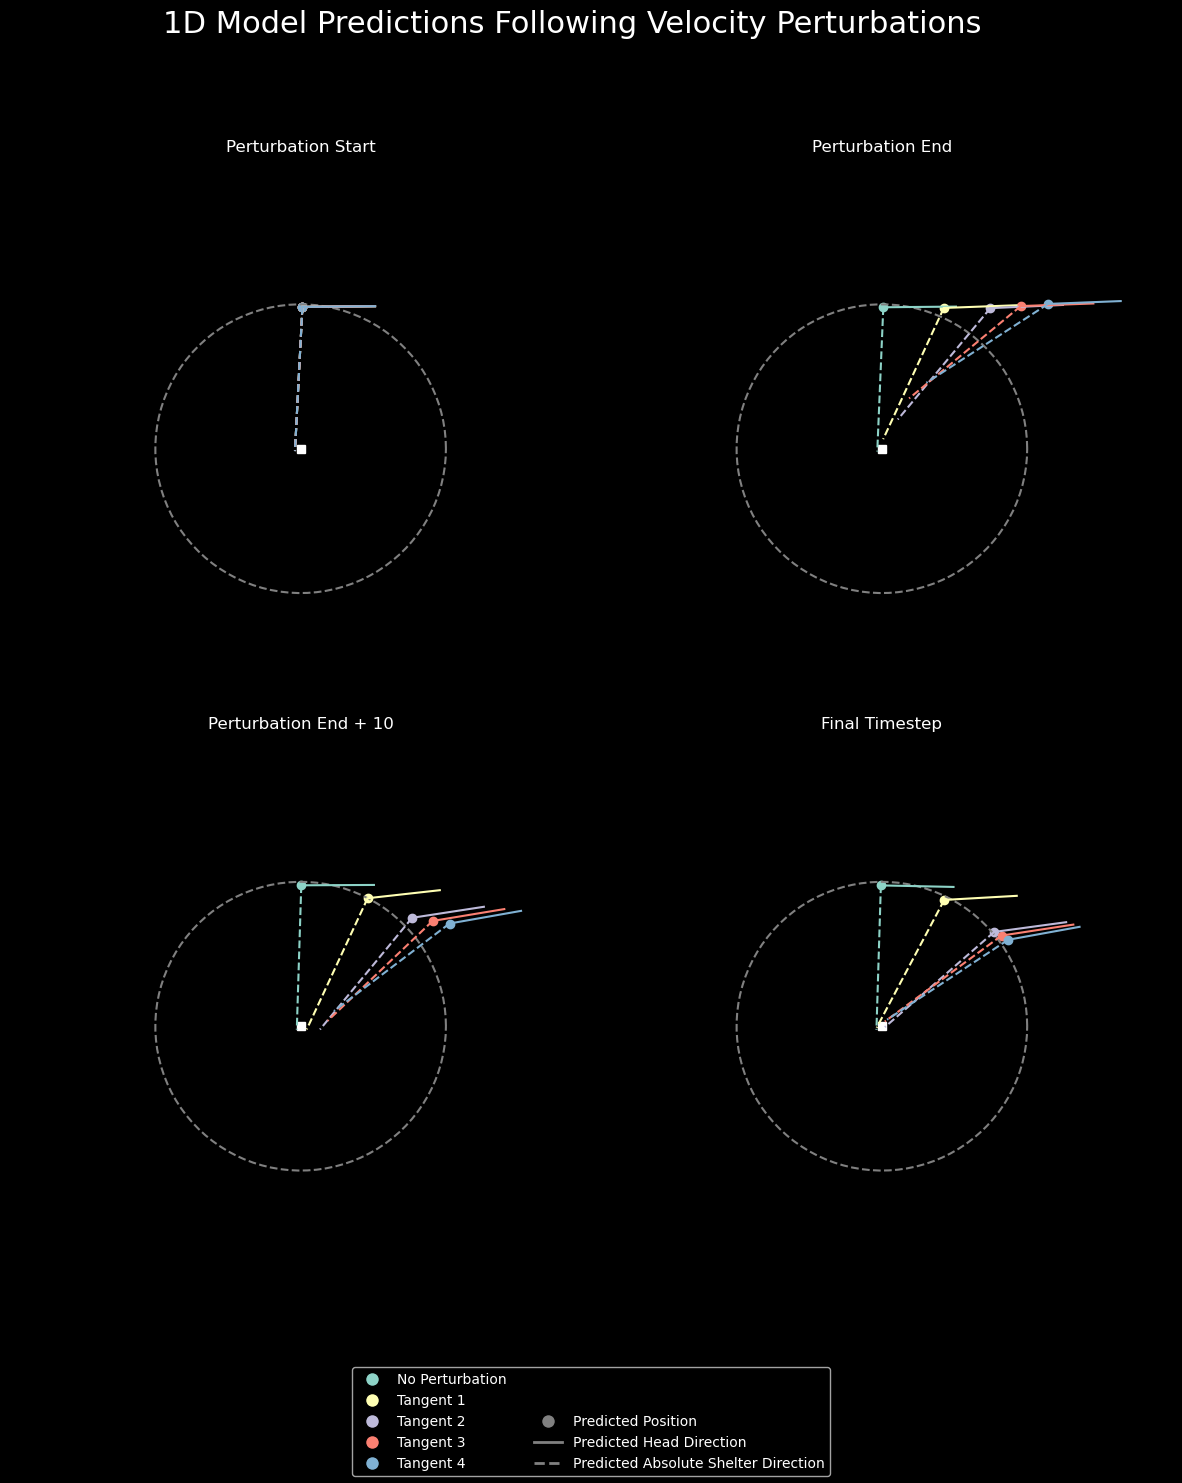

In [15]:
"""
Plot results of knocking 1D mouse tangentially in the head direction at 4 increasing strengths
"""

n_trials = 5
trial_labels = ['No Perturbation', 'Tangent 1', 'Tangent 2', 'Tangent 3', 'Tangent 4']
initial_hd = torch.zeros((n_trials, 1))
initial_x = np.pi/2 * torch.ones((n_trials, 1))

inputs = torch.zeros((n_trials, task.config.n_timesteps, task.config.n_inputs))
inputs[:,:task.config.init_duration,task.input_map['sin_hd_0']] = torch.sin(initial_hd).repeat((1,task.config.init_duration))
inputs[:,:task.config.init_duration,task.input_map['cos_hd_0']] = torch.cos(initial_hd).repeat((1,task.config.init_duration))
inputs[:,:task.config.init_duration,task.input_map['sin_x_0']] = torch.sin(initial_x).repeat((1,task.config.init_duration))
inputs[:,:task.config.init_duration,task.input_map['cos_x_0']] = torch.cos(initial_x).repeat((1,task.config.init_duration))

move_start_t, move_end_t = 50, 55
move_v = 0.1
total_dist = (move_end_t - move_start_t) * move_v

for i in range(1, n_trials):
    inputs[i, move_start_t:move_end_t, task.input_map['xv']] = move_v * i

with torch.no_grad():
    outputs = net(inputs)[2]

fig, axs = plt.subplots(2, 2, figsize=(15, 15), gridspec_kw={'hspace':0, 'wspace':0})
time_points = [move_start_t-1, move_end_t-1, move_end_t + 10, task.config.n_timesteps - 1]
titles = ['Perturbation Start', 'Perturbation End', 'Perturbation End + 10', 'Final Timestep']
colors = matplotlib.colormaps['Set3'](np.arange(n_trials))

for ax, t, title in zip(axs.flatten(), time_points, titles):
    ax.set_axis_off()
    ax.set_xlim([-2, 2])
    ax.set_ylim([-2, 2])
    ax.plot(np.cos(np.linspace(0, 2 * np.pi, 100)), np.sin(np.linspace(0, 2 * np.pi, 100)), color='gray', linestyle='--')
    ax.plot(0, 0, 'ws')  # White square at the origin
    ax.set_title(title)
    
    for trial in range(n_trials):
        x = outputs[trial, t, task.target_map['cos_x']]
        y = outputs[trial, t, task.target_map['sin_x']]
        hd = torch.atan2(outputs[trial, t, task.target_map['sin_hd']], outputs[trial, t, task.target_map['cos_hd']])
        sd = torch.atan2(outputs[trial, t, task.target_map['sin_sd']], outputs[trial, t, task.target_map['cos_sd']])
        ad = hd + sd

        ax.scatter(x, y, label=trial_labels[trial], color=colors[trial])
        ax.plot([x, x + 0.5 * torch.cos(hd)], [y, y + 0.5 * torch.sin(hd)], color=colors[trial])
        ax.plot([x, x + 1 * torch.cos(ad)], [y, y + 1 * torch.sin(ad)], linestyle='--', color=colors[trial])

# Create a legend
legend_elements = []
for trial, label in enumerate(trial_labels):
    legend_elements.append(plt.Line2D([0], [0], marker='o', color='black', markerfacecolor=colors[trial], markersize=10, label=label, linestyle='None'))

# Add dummy elements to ensure the 'predicted' variable elements are in a separate column
for _ in range(len(trial_labels) - 3):
    legend_elements.append(plt.Line2D([0], [0], color='none', label=''))

legend_elements.extend([
    plt.Line2D([0], [0], marker='o', color='black', markerfacecolor='gray', markersize=10, label='Predicted Position', linestyle='None'),
    plt.Line2D([0], [0], color='gray', lw=2, label='Predicted Head Direction'),
    plt.Line2D([0], [0], linestyle='--', color='gray', lw=2, label='Predicted Absolute Shelter Direction')
])

fig.legend(handles=legend_elements, loc='lower center', ncol=2)
fig.suptitle('1D Model Predictions Following Velocity Perturbations', fontsize=22)
plt.show()
